# COLETA DE DADOS

In [20]:
!pip install kagglehub
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

import kagglehub
DATASET_PATH = os.environ.get("DATASET_PATH") or kagglehub.dataset_download(
    'hkayan/industrial-robotic-arm-imu-data-casper-1-and-2') + '/'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [22]:
import re
normalPattern = "IMU_(.*)Hz.csv"

normal = ("IMU_10Hz.csv", ("label", 0))
faulty =("IMU_hitting_platform.csv", ("label", 1))

df = pd.read_csv(DATASET_PATH + normal[0])
df['label'] = 0

faultydf = pd.read_csv(DATASET_PATH+faulty[0])
faultydf['label'] = 1



In [23]:
print("--- CARREGAMENTO MANUAL DE CENÁRIOS ---")

# 1. Carregar o NORMAL (df)
# ------------------------------------------------------------------
print("Lendo Base Normal...")
df = pd.read_csv(DATASET_PATH + 'IMU_10Hz.csv')
df['label'] = 0
df['scenario'] = 'Normal'

# 2. Carregar AS ANOMALIAS (faultydf)
# ------------------------------------------------------------------
print("Lendo Base de Falhas...")

# Lista simples e direta com TODOS os arquivos de problema disponíveis
arquivos_falha = [
    'IMU_hitting_platform.csv',   # Colisão: Plataforma
    'IMU_hitting_arm.csv',        # Colisão: Braço (Robô se batendo)
    'IMU_extra_weigth.csv',       # Mecânico: Peso Extra (Esforço)
    'IMU_earthquake.csv',         # Ambiental: Terremoto (Vibração externa)
]

lista_dfs = []

for arquivo in arquivos_falha:
    # Carrega cada um individualmente
    temp_df = pd.read_csv(DATASET_PATH + arquivo)

    # Padroniza
    temp_df['label'] = 1             # Todo mundo aqui é erro
    temp_df['scenario'] = arquivo    # Guarda o nome pra você saber o que é

    lista_dfs.append(temp_df)
    print(f"-> Adicionado: {arquivo} ({len(temp_df)} linhas)")

# Junta todos os arquivos da lista em um só DataFrame
faultydf = pd.concat(lista_dfs, ignore_index=True)

print("="*60)
print(f"DATASET PRONTO:")
print(f"-> Dados Normais: {len(df)} linhas")
print(f"-> Dados de Falha:  {len(faultydf)} linhas (Total de 4 tipos de defeito)")

--- CARREGAMENTO MANUAL DE CENÁRIOS ---
Lendo Base Normal...
Lendo Base de Falhas...
-> Adicionado: IMU_hitting_platform.csv (14967 linhas)
-> Adicionado: IMU_hitting_arm.csv (11924 linhas)
-> Adicionado: IMU_extra_weigth.csv (10885 linhas)
-> Adicionado: IMU_earthquake.csv (11409 linhas)
DATASET PRONTO:
-> Dados Normais: 874937 linhas
-> Dados de Falha:  49185 linhas (Total de 4 tipos de defeito)


# ANÁLISE EXPLORATÓRIA DOS DADOS

## Entendendo o movimento do robô

### Peridiocidade
- Como o robô executa tarefas sequenciais, os dados geram uma assinatura periódica.
- Nos gráficos, as ondas devem se repetir em intervalos fixos com o padrão do acelerômetro idêntico. Se o ciclo atrasa, acelera ou a forma da onda muda, existe uma anomalia.

### Acelerômetro
- O acelerômetro mede a vibração e a gravidade. Picos repentinos indicam movimentos bruscos como uma colisão ou vibrações externas. Oscilações suaves representam a inclinação do braço em relação à gravidade.

### Giroscópio
- O giroscópio mede a velocidade angular. É o sensor mais sensível para detectar mudanças na agilidade do movimento. Se o braço estiver com peso extra, ele pode demorar mais para atingir a velocidade de pico ou apresentar oscilações ao tentar frear.

### Magnetômetro
- O magnetômetro muda lentamente conforme o braço gira e altera sua orientação em relação ao norte magnético. Anomalias incluem uma distorção súbita no magnetômetro que não é acompanhada por um movimento correspondente no giroscópio.

## Análise Exploratória Estrutural [Classe Normal]
- Informações básicas do dataset
- Tipos de dados
- Informações detalhadas
- Estatísticas descritivas
- Análise de valores únicos

In [24]:
df.head()

name                 time      accX      accY      accZ   gyroX   gyroY  \
0  IMU8  1686062828391000000  9.773131  0.232238  0.490811 -0.1250  0.0000   
1  IMU8  1686062828537000000  9.806650  0.263362  0.488417  0.0625  0.0000   
2  IMU8  1686062828585000000  9.794679  0.251391  0.442927 -0.1875  0.0000   
3  IMU8  1686062828682000000  9.770737  0.222661  0.445322 -0.0625  0.0625   
4  IMU8  1686062828780000000  9.792285  0.222661  0.464475  0.0000  0.0000   

   gyroZ       magX  magY       magZ  label scenario  
0    0.0   0.000000  0.00   0.000000      0   Normal  
1    0.0 -48.279999 -7.44 -13.230769      0   Normal  
2    0.0 -48.560001 -7.48 -13.230769      0   Normal  
3    0.0 -48.520000 -7.32 -13.461538      0   Normal  
4    0.0 -48.360001 -7.28 -13.692307      0   Normal

- Convertendo `time` de nanossegundos para milissegundos para facilitar a análise de integridade temporal

In [25]:
df['time'] = (df['time'].map(lambda x: x/1e6))
faultydf['time'] = (faultydf['time'].map(lambda x: x/1e6))

- Removendo a coluna `name` pois não agrega valor preditivo

In [26]:
df = df.drop(columns=['name', 'scenario'])

- Verificando duplicatas

In [27]:
print(f"[Normal] Duplicatas de Tempo: {df['time'].duplicated().any()}")

[Normal] Duplicatas de Tempo: False


In [28]:
def analise_estrutural_sensores(df, time_col='time', label_col='label'):
    """
    Realiza uma análise exploratória estrutural focada em dados de sensores (Séries Temporais).
    
    Args:
        df: DataFrame com os dados.
        time_col: Nome da coluna de tempo.
        label_col: Nome da coluna de target (anomalia/normal).
    """
    
    print("="*60)
    print("1. INFORMAÇÕES BÁSICAS E TIPOS DE DADOS")
    print("="*60)
    print(f"Dimensões do Dataset: {df.shape[0]} linhas, {df.shape[1]} colunas")
    print("\nTipos de Dados (Dtypes):")
    print(df.dtypes)
    
    # Verificação de memória
    memoria = df.memory_usage(deep=True).sum() / 1024**2
    print(f"\nUso de Memória: {memoria:.2f} MB")

    print("\n" + "="*60)
    print("2. ANÁLISE DE INTEGRIDADE TEMPORAL (CRÍTICO PARA IMU)")
    print("="*60)
    
    # Ordenar por tempo para garantir análise correta
    df = df.sort_values(by=time_col)
    
    # Calcular diferenças de tempo (Delta T)
    delta_t = df[time_col].diff().dropna()
    
    mean_dt = delta_t.mean()
    std_dt = delta_t.std()
    min_dt = delta_t.min()
    max_dt = delta_t.max()
    
    print(f"- Intervalo de Amostragem Médio (Sampling Rate): {mean_dt:.6f} ms")
    print(f"- Frequência de coleta de dados: {1/(df['time'].diff().mean()/1000):.2f} Hz")
    print(f"- Jitter (Desvio Padrão do tempo): {std_dt:.6f} ms")
    print(f"- Gap Mínimo: {min_dt:.6f} ms | Gap Máximo: {max_dt:.6f} ms")
    
    # Verificar se há gaps significativos (perda de pacotes)
    # Exemplo: Se o gap for maior que 2x a média, é uma quebra de continuidade
    gaps = (delta_t > 2 * mean_dt).sum()
    print(f"- Qtd. de Gaps Temporais Significativos (> 2x média): {gaps}")
    
    print("\n" + "="*60)
    print("3. ANÁLISE DE VALORES ÚNICOS E CONSTANTES (SENSOR FREEZE)")
    print("="*60)
    
    # Separa colunas de sensores (excluindo tempo e label)
    cols_sensores = [c for c in df.columns if c not in [time_col, label_col]]
    
    resumo_unicos = pd.DataFrame({
        'Tipo': df[cols_sensores].dtypes,
        'Qtd_Unicos': df[cols_sensores].nunique(),
        'Unicos (%)': (df[cols_sensores].nunique() / len(df)) * 100,
        'Qtd_Zeros': (df[cols_sensores] == 0).sum(),
        'Zeros (%)': ((df[cols_sensores] == 0).sum() / len(df)) * 100
    })
    
    display(resumo_unicos.sort_values('Qtd_Unicos'))
    
    # Alerta para colunas com baixíssima variabilidade (Sensor travado ou irrelevante)
    cols_travadas = resumo_unicos[resumo_unicos['Qtd_Unicos'] == 1].index.tolist()
    if cols_travadas:
        print(f"\n[ALERTA] Colunas com valor constante (irrelevantes): {cols_travadas}")
    else:
        print("\n[OK] Nenhuma coluna totalmente constante detectada.")

    print("\n" + "="*60)
    print("4. ESTATÍSTICAS DESCRITIVAS DETALHADAS (MOMENTOS)")
    print("="*60)
    # Inclui Skewness e Kurtosis que são vitais para detectar desvios de normalidade em sinais
    desc = df[cols_sensores].describe().T
    desc['skewness'] = df[cols_sensores].skew()
    desc['kurtosis'] = df[cols_sensores].kurt()
    
    display(desc[['mean', 'std', 'min', '50%', 'max', 'skewness', 'kurtosis']])

    print("\n" + "="*60)
    print("5. BALANCEAMENTO DAS CLASSES (TARGET)")
    print("="*60)
    if label_col in df.columns:
        contagem = df[label_col].value_counts()
        percentual = df[label_col].value_counts(normalize=True) * 100
        
        balanceamento = pd.DataFrame({'Contagem': contagem, 'Percentual (%)': percentual})
        print(balanceamento)
        
        ratio = contagem.max() / contagem.min() if len(contagem) > 1 else 0
        print(f"\nRazão de Desbalanceamento: 1 : {ratio:.1f}")
    else:
        print(f"Coluna de target '{label_col}' não encontrada.")

In [29]:
analise_estrutural_sensores(df, time_col='time', label_col='label')

1. INFORMAÇÕES BÁSICAS E TIPOS DE DADOS
Dimensões do Dataset: 874937 linhas, 11 colunas

Tipos de Dados (Dtypes):
time     float64
accX     float64
accY     float64
accZ     float64
gyroX    float64
gyroY    float64
gyroZ    float64
magX     float64
magY     float64
magZ     float64
label      int64
dtype: object

Uso de Memória: 73.43 MB

2. ANÁLISE DE INTEGRIDADE TEMPORAL (CRÍTICO PARA IMU)
- Intervalo de Amostragem Médio (Sampling Rate): 100.161111 ms
- Frequência de coleta de dados: 9.98 Hz
- Jitter (Desvio Padrão do tempo): 20.742487 ms
- Gap Mínimo: 1.999756 ms | Gap Máximo: 342.000000 ms
- Qtd. de Gaps Temporais Significativos (> 2x média): 429

3. ANÁLISE DE VALORES ÚNICOS E CONSTANTES (SENSOR FREEZE)


Tipo  Qtd_Unicos  Unicos (%)  Qtd_Zeros  Zeros (%)
magX   float64         934    0.106751          1   0.000114
accZ   float64        1036    0.118409        665   0.076005
gyroY  float64        1298    0.148354     158864  18.157193
magZ   float64        1417    0.161955        332   0.037946
magY   float64        2241    0.256133        254   0.029031
gyroX  float64        2875    0.328595     105533  12.061783
gyroZ  float64        3441    0.393285     111669  12.763090
accX   float64        4430    0.506322          0   0.000000
accY   float64        7541    0.861891      10572   1.208316


[OK] Nenhuma coluna totalmente constante detectada.

4. ESTATÍSTICAS DESCRITIVAS DETALHADAS (MOMENTOS)


mean        std         min        50%         max  skewness  \
accX    9.269243   1.516315    1.156399   9.852139   12.066776 -2.739166   
accY   -0.679584   3.081915   -9.847351  -0.038307    8.475473 -0.762666   
accZ    0.495106   0.234830   -0.835576   0.495600    1.908179  0.284244   
gyroX   0.348747  28.019503  -81.750000   0.000000   98.062500  0.491446   
gyroY   0.663905   8.082524  -27.875000   0.000000   53.250000  2.871021   
gyroZ   0.018216  26.374499 -100.937500   0.000000  114.125000  0.465529   
magX  -33.343776   5.845444  -51.639999 -35.160000    0.000000  1.755210   
magY   19.589580  19.280610  -48.759998  30.200001   40.959999 -1.671453   
magZ   -2.480548  31.454652  -59.384617   6.615385   52.769230 -0.093653   

        kurtosis  
accX    7.740546  
accY    1.868484  
accZ    1.645130  
gyroX   2.317646  
gyroY  17.121582  
gyroZ   4.292307  
magX    3.541038  
magY    2.005146  
magZ   -1.193974


5. BALANCEAMENTO DAS CLASSES (TARGET)
       Contagem  Percentual (%)
label                          
0        874937           100.0

Razão de Desbalanceamento: 1 : 0.0


### Análise de Integridade Temporal

- 10Hz é uma frequência baixa para vibrações mecânicas finas, mas aceitável para movimentos macroscópicos de braços robóticos.
- Jitter alto (em torno de 20ms), o intervalo entre leituras varia muito. Possivelmente irá introduzir ruído ao utilizar Redes Neurais (CNN/LSTM).
- Existem 429 momentos onde o sistema perde pacotes, com um gap máximo de 342ms, isso quebra a continuidade da janela deslizante. Será necessário fazer um Resampling para forçar um passo de tempo fixo (ex: interpolar para 100ms exatos) antes de alimentar o modelo.

### Análise de valores únicos e constantes
- A coluna `name` tem apenas 1 valor único e é irrelevante para o problema de detecção de anomalias, ela não agrega valor preditivo. Será necessário fazer um drop da coluna.
- `gyroY` tem 18% de zeros, o braço robótico passa muito tempo parado (idle). Como 18% é um valor relativamente alto, pode ser considerado definir "estar parado" como um comportamnto Normal (considerar "Zero" como classe Normal).
- `magX` possui baixa variablidade, pode ser recomendado testar treinar com e sem ele (feature selection).

### Análise das estatísticas descritivas
- O desvio padrão de `accZ` é muito baixo comparado aos outros, possuindo baixa informação preditiva. É um candidato a ser removido se precisar reduzir dimensionalidade (feature selection).
- A mediana de `gyroY` = 0 confirma que o robô passa a maior parte do tempo parado ou em movimento linear constante (sem rotação). No entanto, uma curtose de 17 é altíssima, isso significa que a distribuição é super pontuda, o que provavelmente acontece é que o robô fica parado quase o tempo todo, mas quando se move, faz movimentos bruscos de início/fim de tarefa. Por isso, qualquer alteração nesse padrão de picos (ex: picos menores = braço lento; picos maiores = colisão) será o principal indicador de anomalia.
- Devido à alta curtose (gyroY) e outliers naturais (máximos de 100+ no gyro), a normalização padrão irá falhar, pois o StandardScaler (Z-score) usa a média e o desvio padrão. Como o desvio padrão é inflado pelos picos, os dados ficarão em um intervalo muito pequeno. A ideia seria usar RobustScaler que usa a mediana e o intervalo interquartil (IQR), ignorando os picos extremos no cálculo da escala, preservando a forma dos picos do giroscópio.

- Visualizando `gyroY`:

In [30]:
def plot_sensor(df, col_sensor, col_time='time'):
    """
    Gera um painel triplo para diagnosticar o comportamento do sensor.
    1. Série Temporal (Visão Geral)
    2. Histograma (Verificar Curtose e Zeros)
    3. Boxplot (Verificar Outliers Extremos)
    """
    
    # Copia para não alterar o original
    df_plot = df.copy()
    
    # Converter tempo para segundos para ficar legível no eixo X
    df_plot['time_sec'] = (df_plot[col_time] - df_plot[col_time].iloc[0]) / 1e3
    
    # Configuração da Figura
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 2)
    
    # --- PLOT 1: SÉRIE TEMPORAL ---
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(df_plot['time_sec'], df_plot[col_sensor], color='#1f77b4', linewidth=0.5, alpha=0.8)
    ax1.set_title(f'Série Temporal: {col_sensor}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Tempo (segundos)', fontsize=12)
    ax1.set_ylabel('Valor do Sensor', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Destacar a linha do Zero (Ociosidade)
    ax1.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Zero (Repouso)')
    ax1.legend()

    # --- PLOT 2: DISTRIBUIÇÃO (HISTOGRAMA + KDE) ---
    ax2 = fig.add_subplot(gs[1, 0])
    # Usamos escala logarítmica no Y devido a quantidade de zeros
    sns.histplot(data=df_plot, x=col_sensor, bins=100, kde=True, ax=ax2, color='#2ca02c')
    ax2.set_yscale('log') # Escala Log para ver as caudas pequenas e o pico gigante
    ax2.set_title(f'Distribuição (Escala Log): {col_sensor}', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Valor do Sensor')
    ax2.set_ylabel('Frequência (Log)')
    
    # Anotação da Curtose
    kurt = df_plot[col_sensor].kurt()
    ax2.text(0.95, 0.95, f'Kurtosis: {kurt:.2f}', transform=ax2.transAxes, 
             horizontalalignment='right', verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # --- PLOT 3: BOXPLOT (DETECÇÃO DE OUTLIERS) ---
    ax3 = fig.add_subplot(gs[1, 1])
    sns.boxplot(x=df_plot[col_sensor], ax=ax3, color='#ff7f0e', fliersize=3)
    ax3.set_title(f'Boxplot de Outliers: {col_sensor}', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Valor do Sensor')
    
    plt.tight_layout()
    plt.show()

In [31]:
sensores = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'magX', 'magY', 'magZ']

### Plot dos Acelerômetros

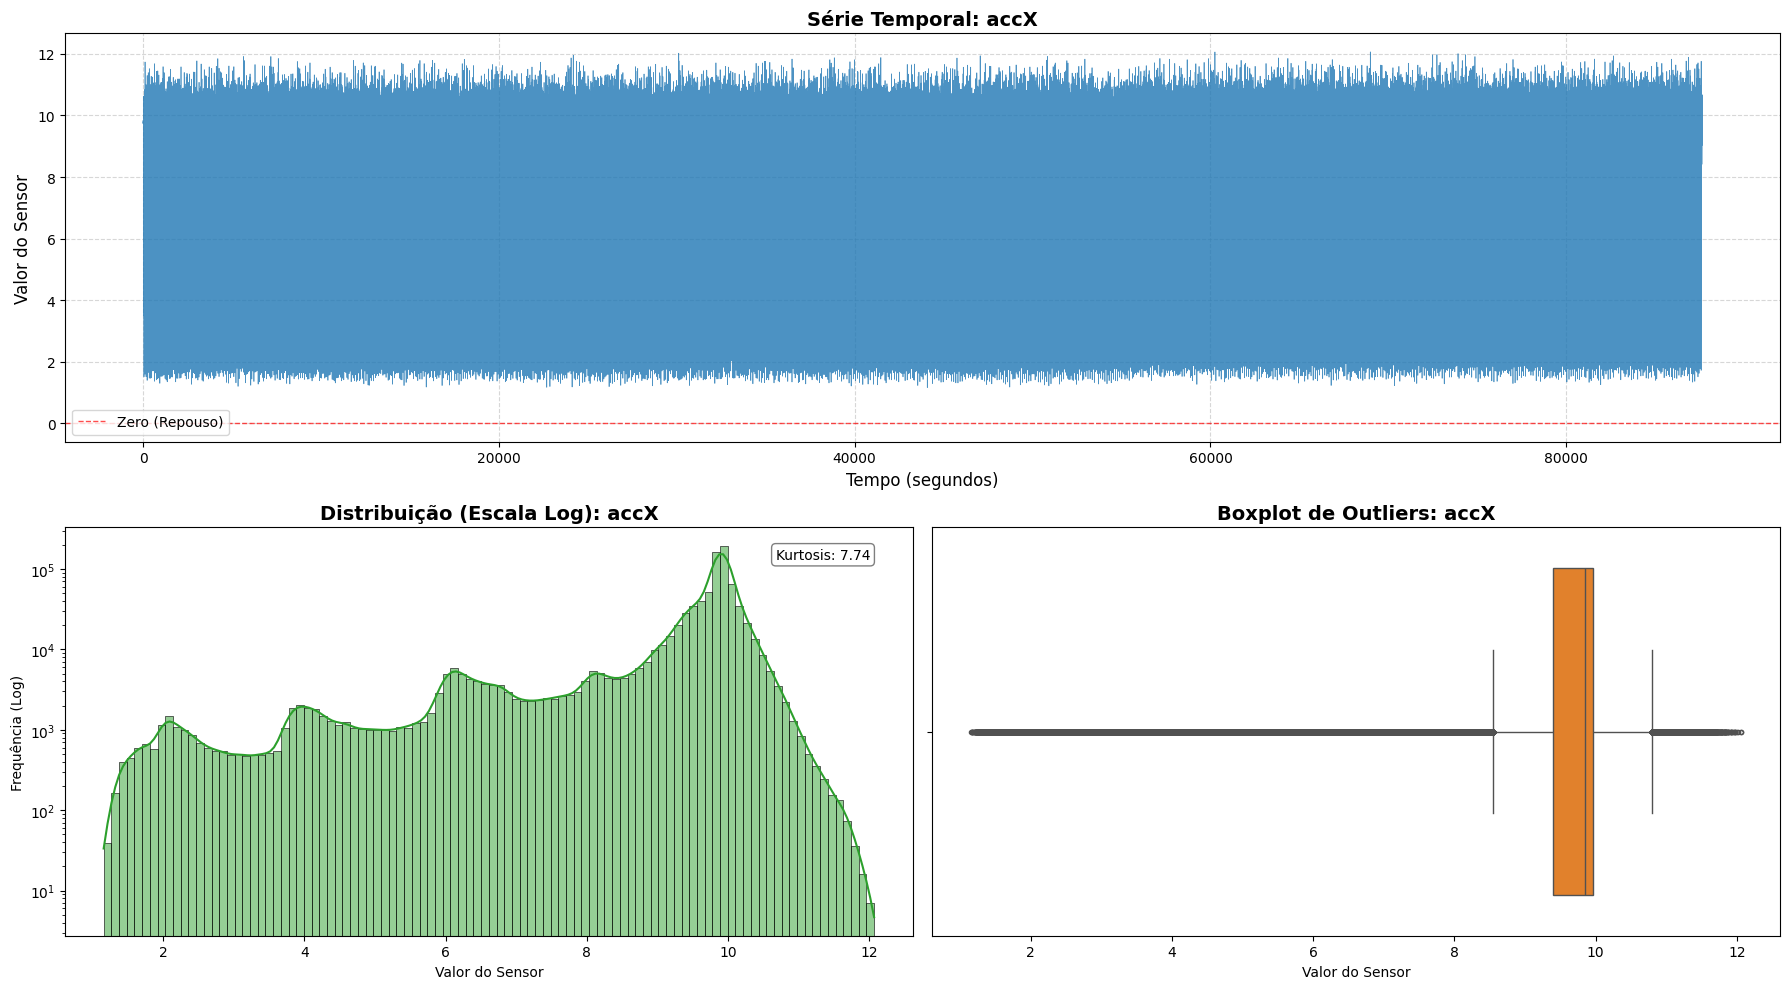

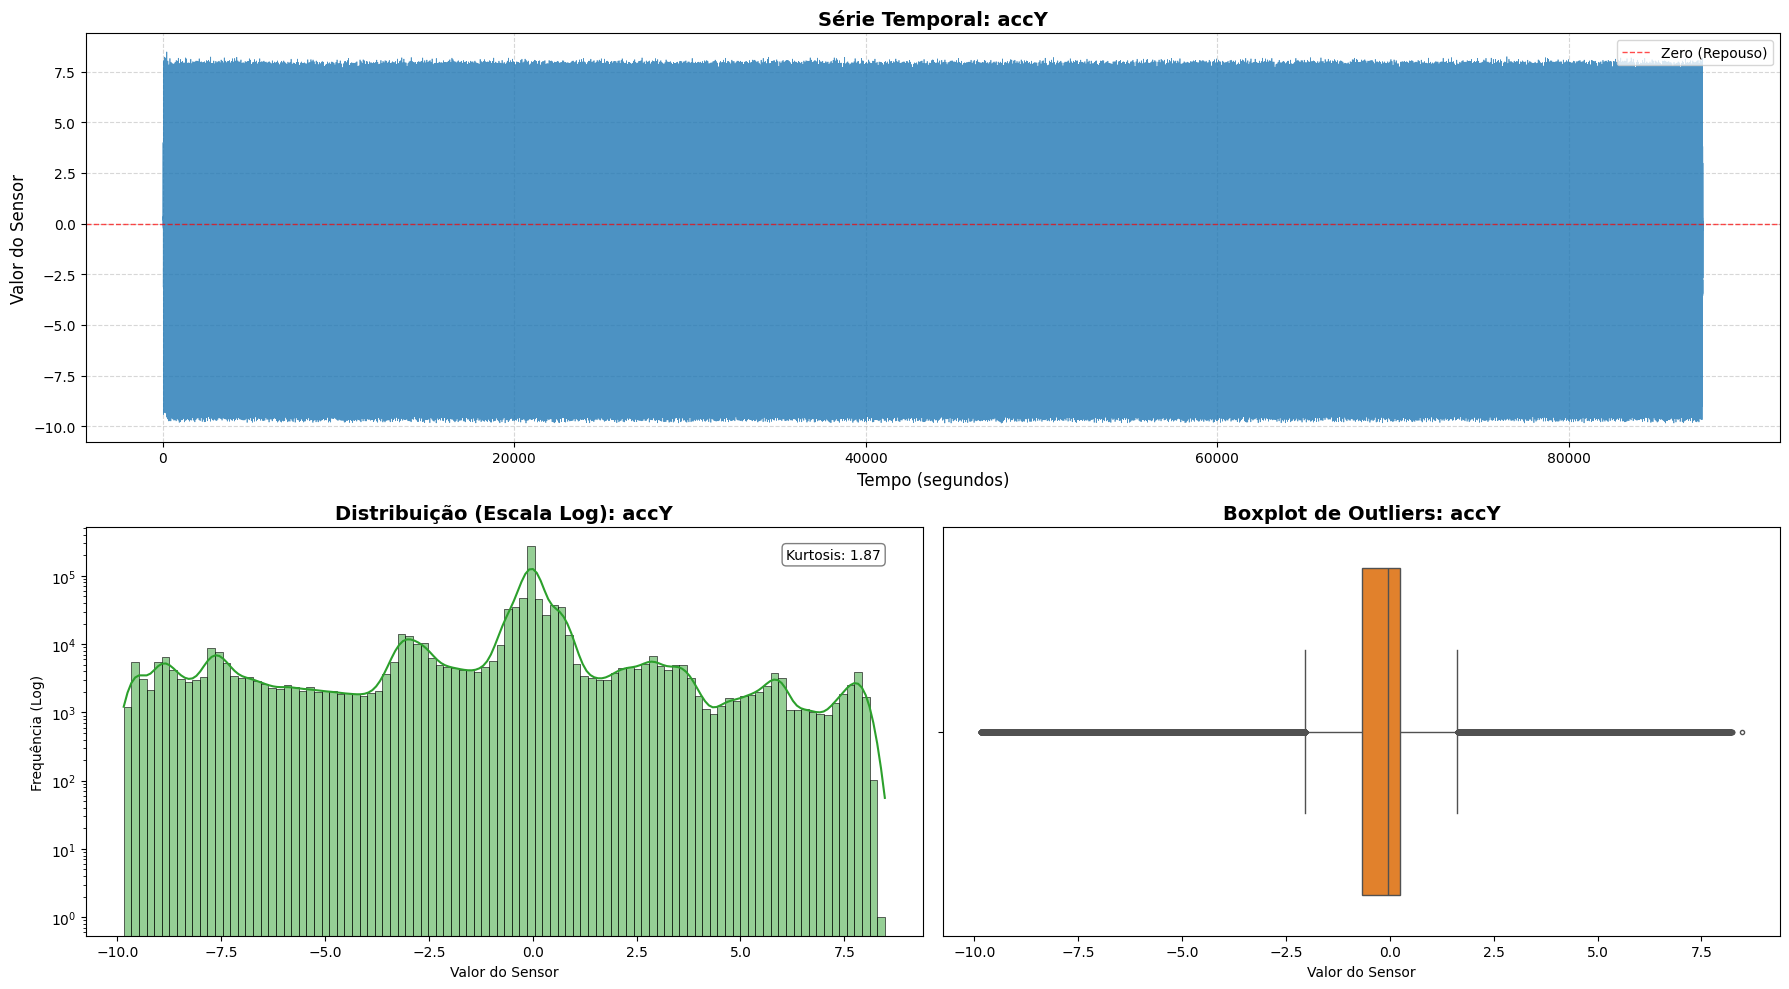

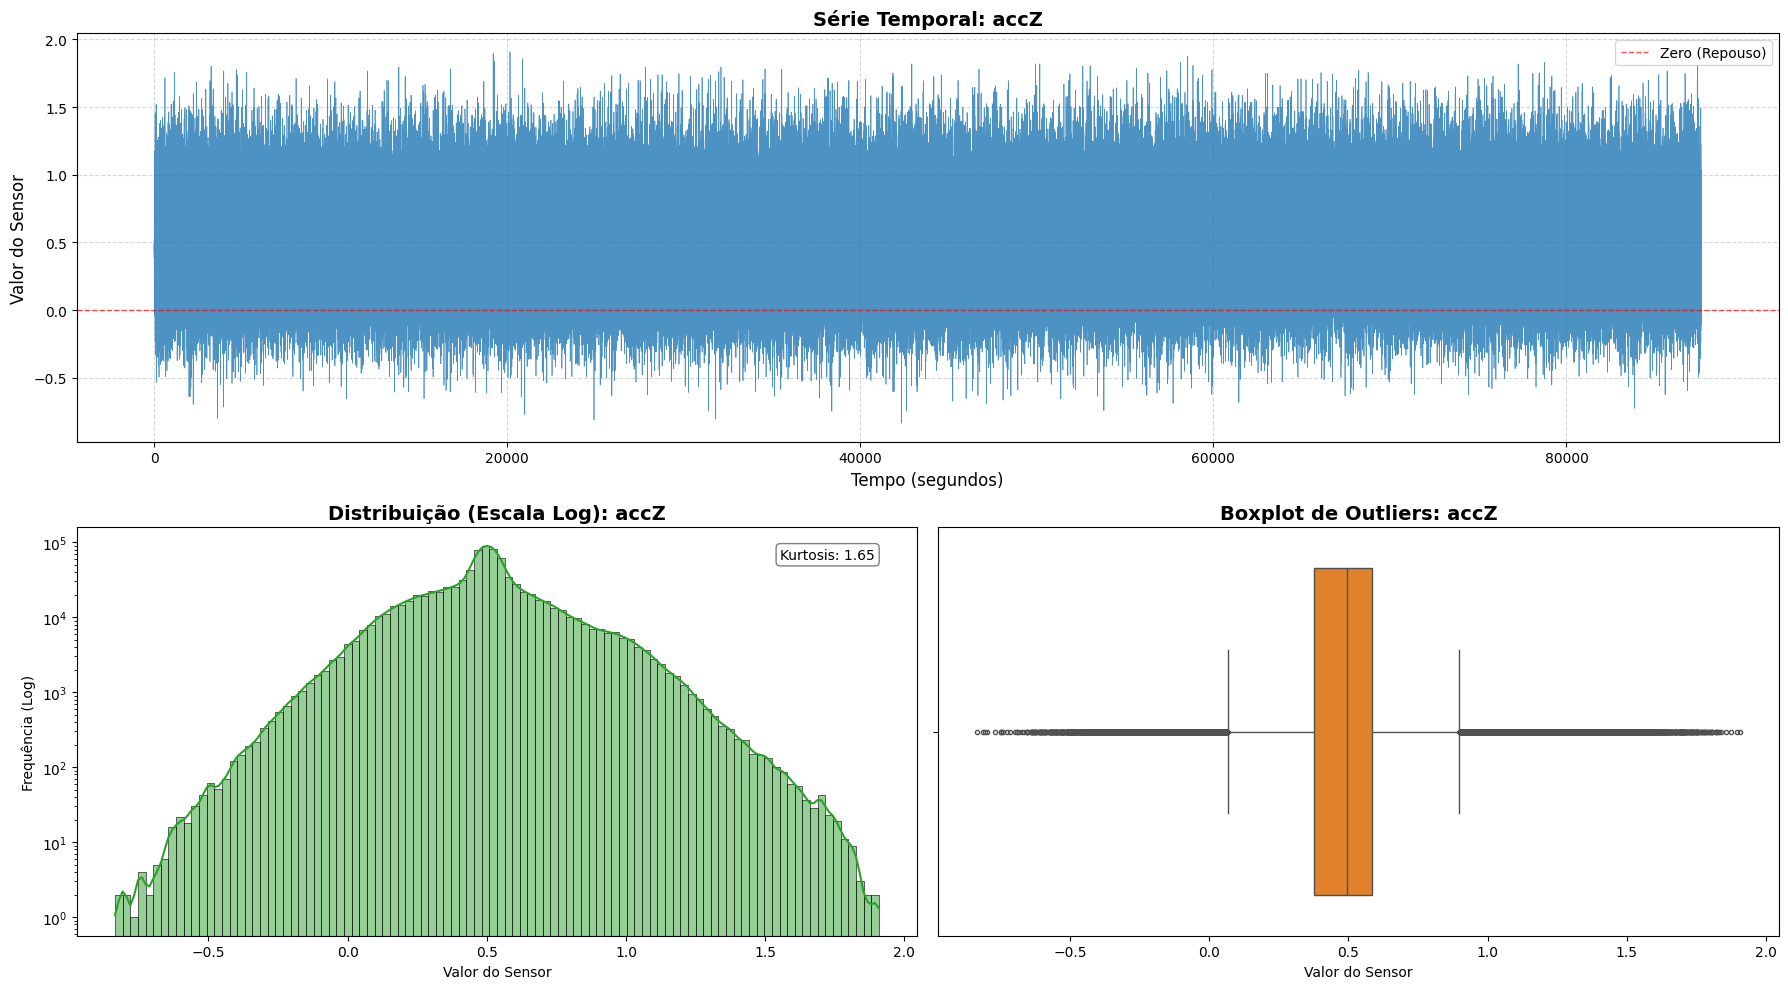

In [32]:
for sensor in sensores[0:3]:
  plot_sensor(df, col_sensor=sensor)

### Plot dos Giroscópios

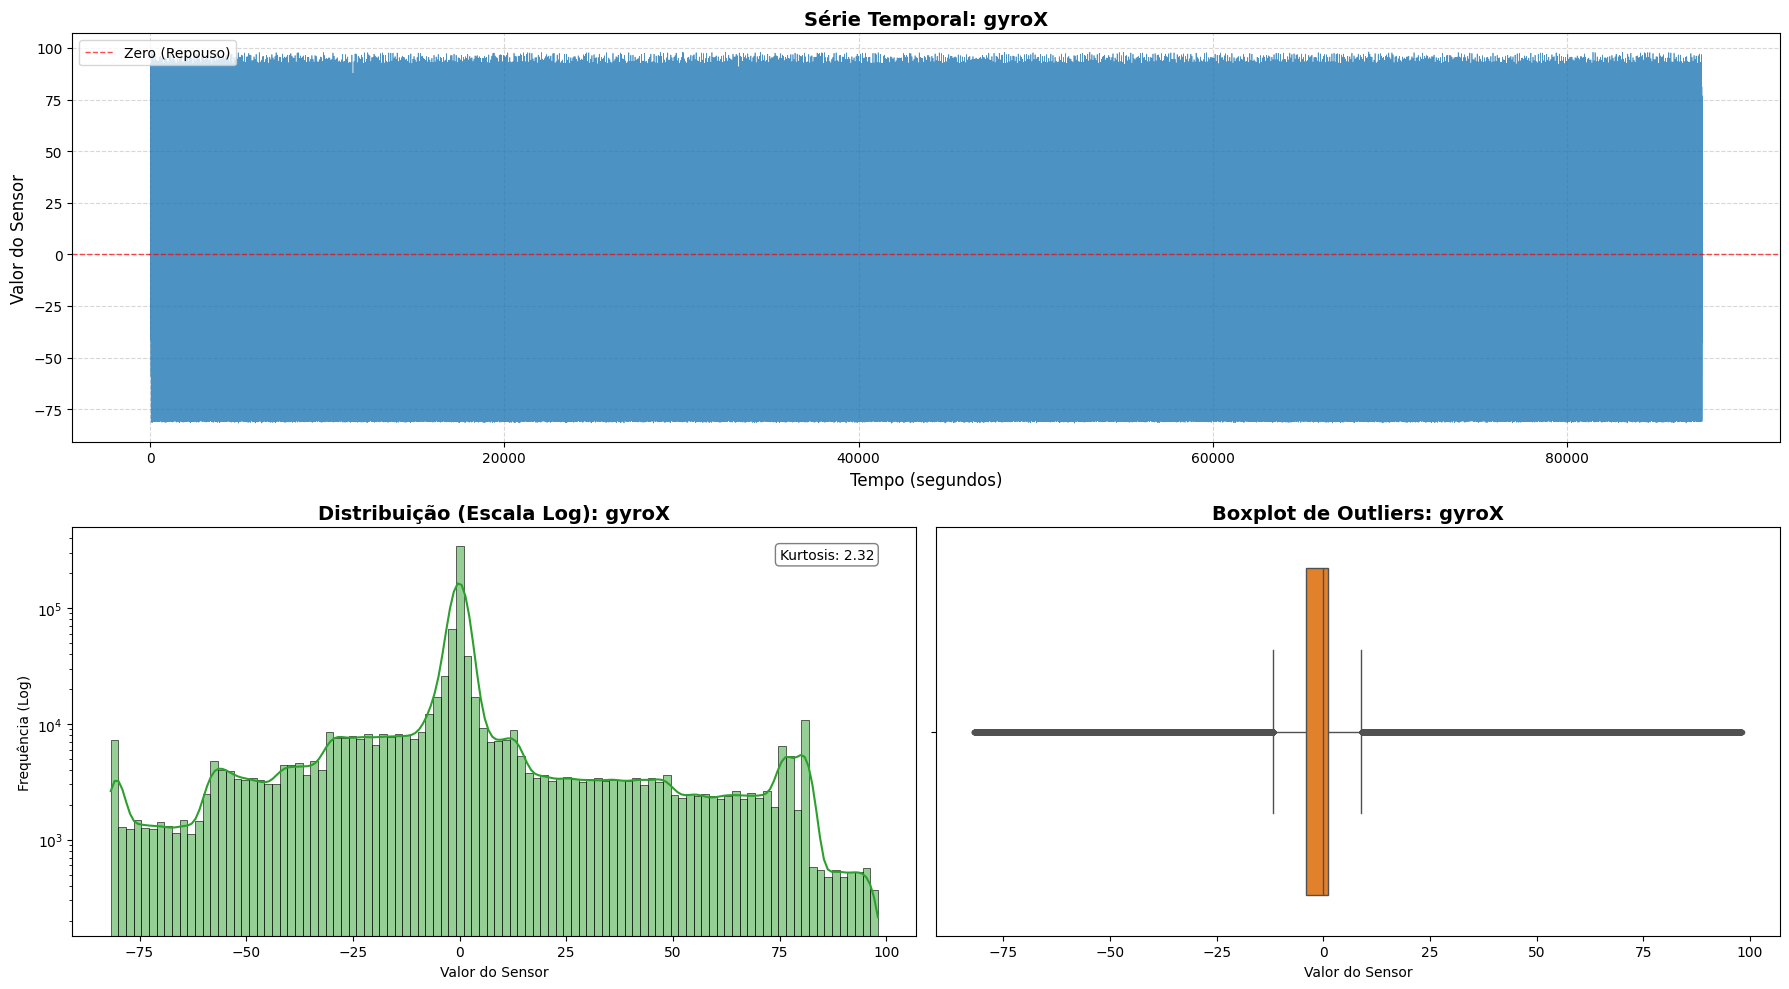

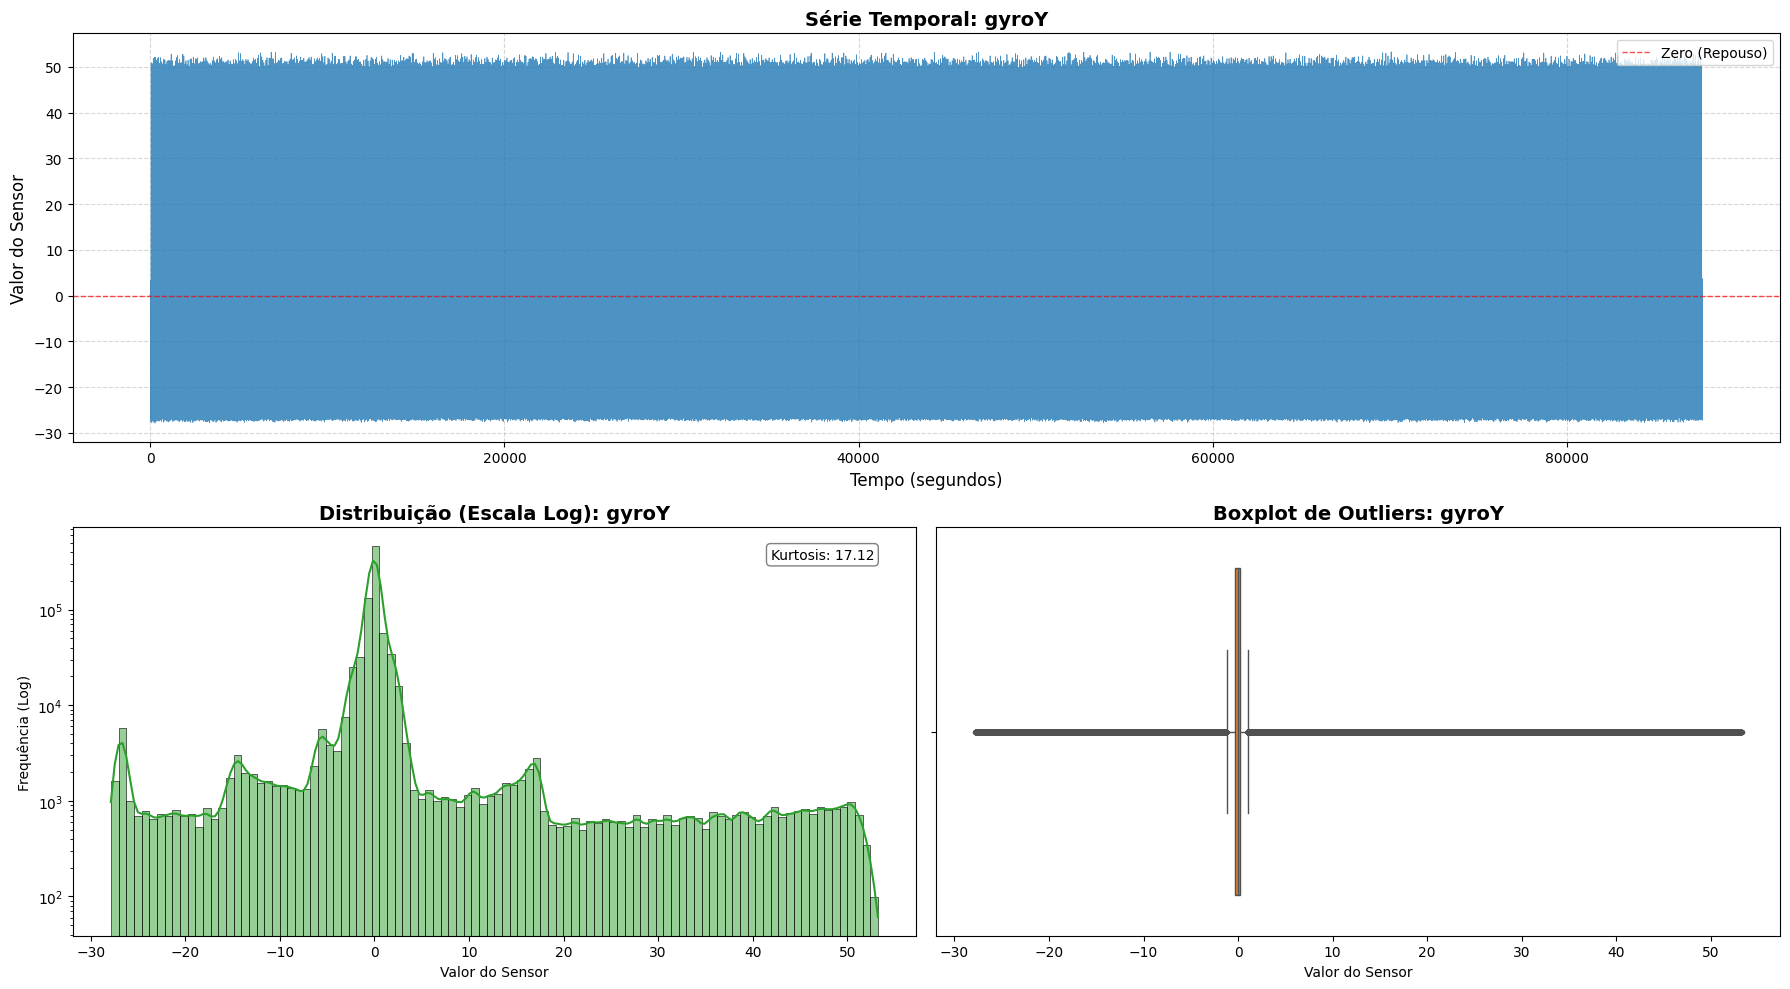

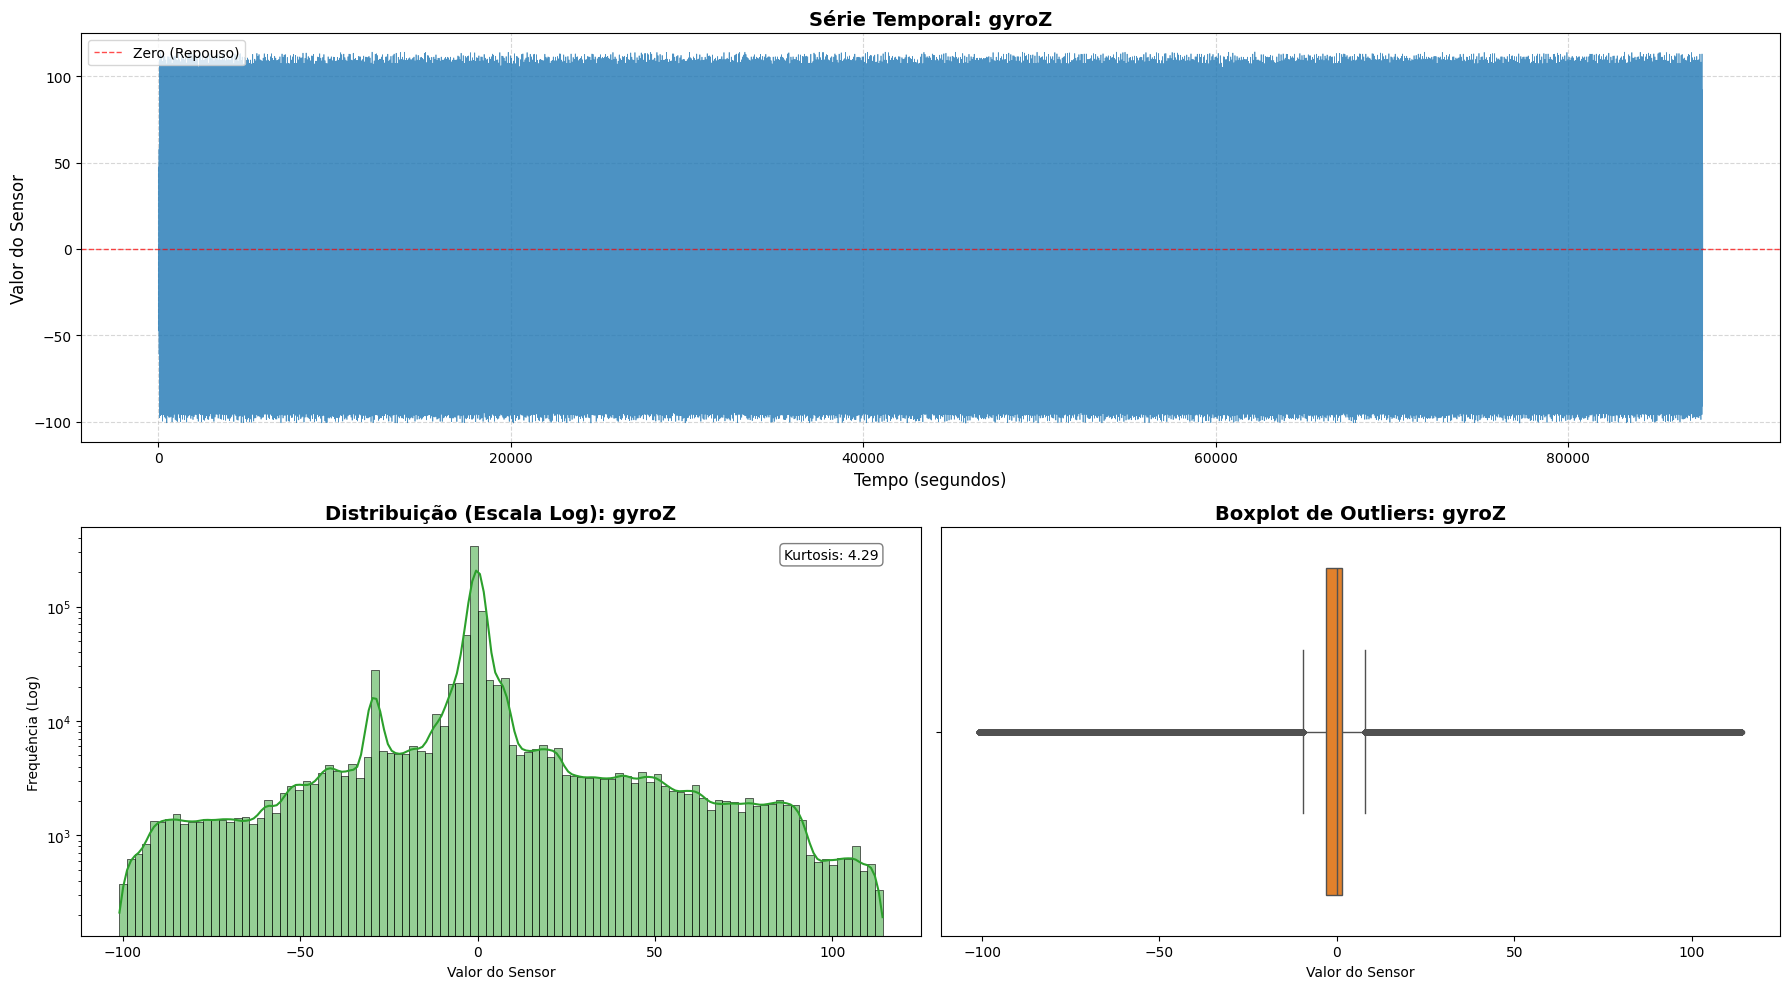

In [33]:
for sensor in sensores[3:6]:
  plot_sensor(df, col_sensor=sensor)

### Plot dos Magnetômetros

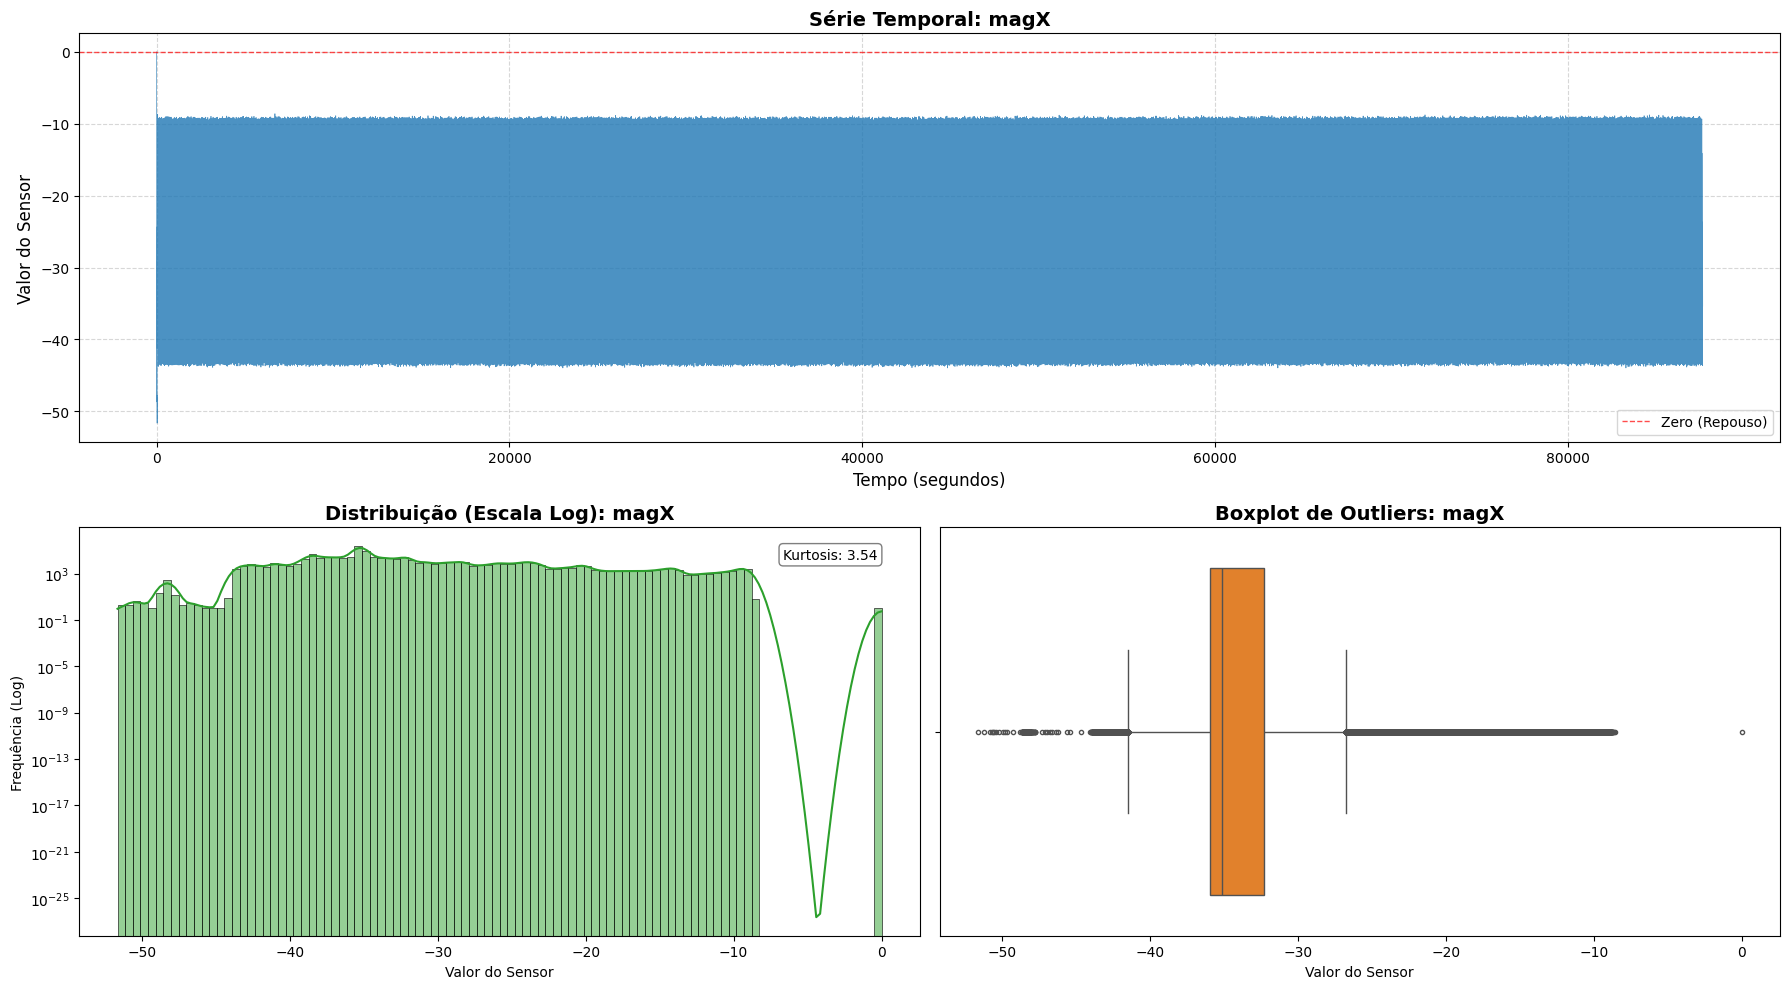

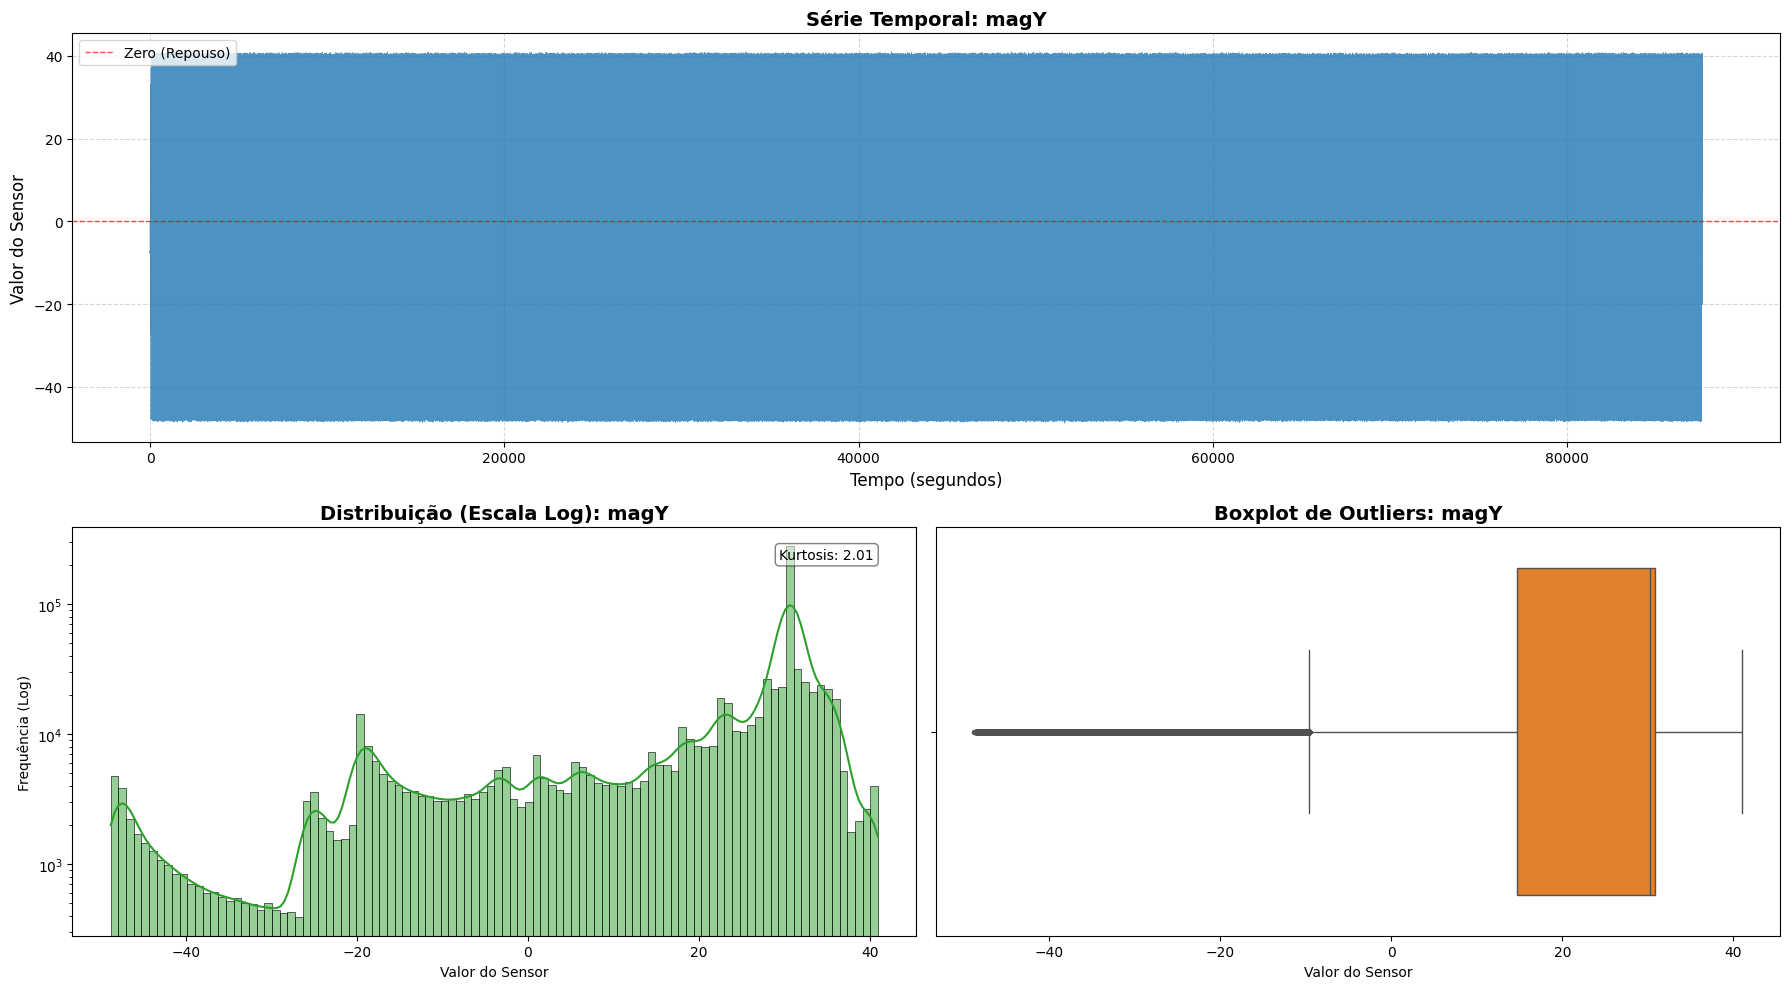

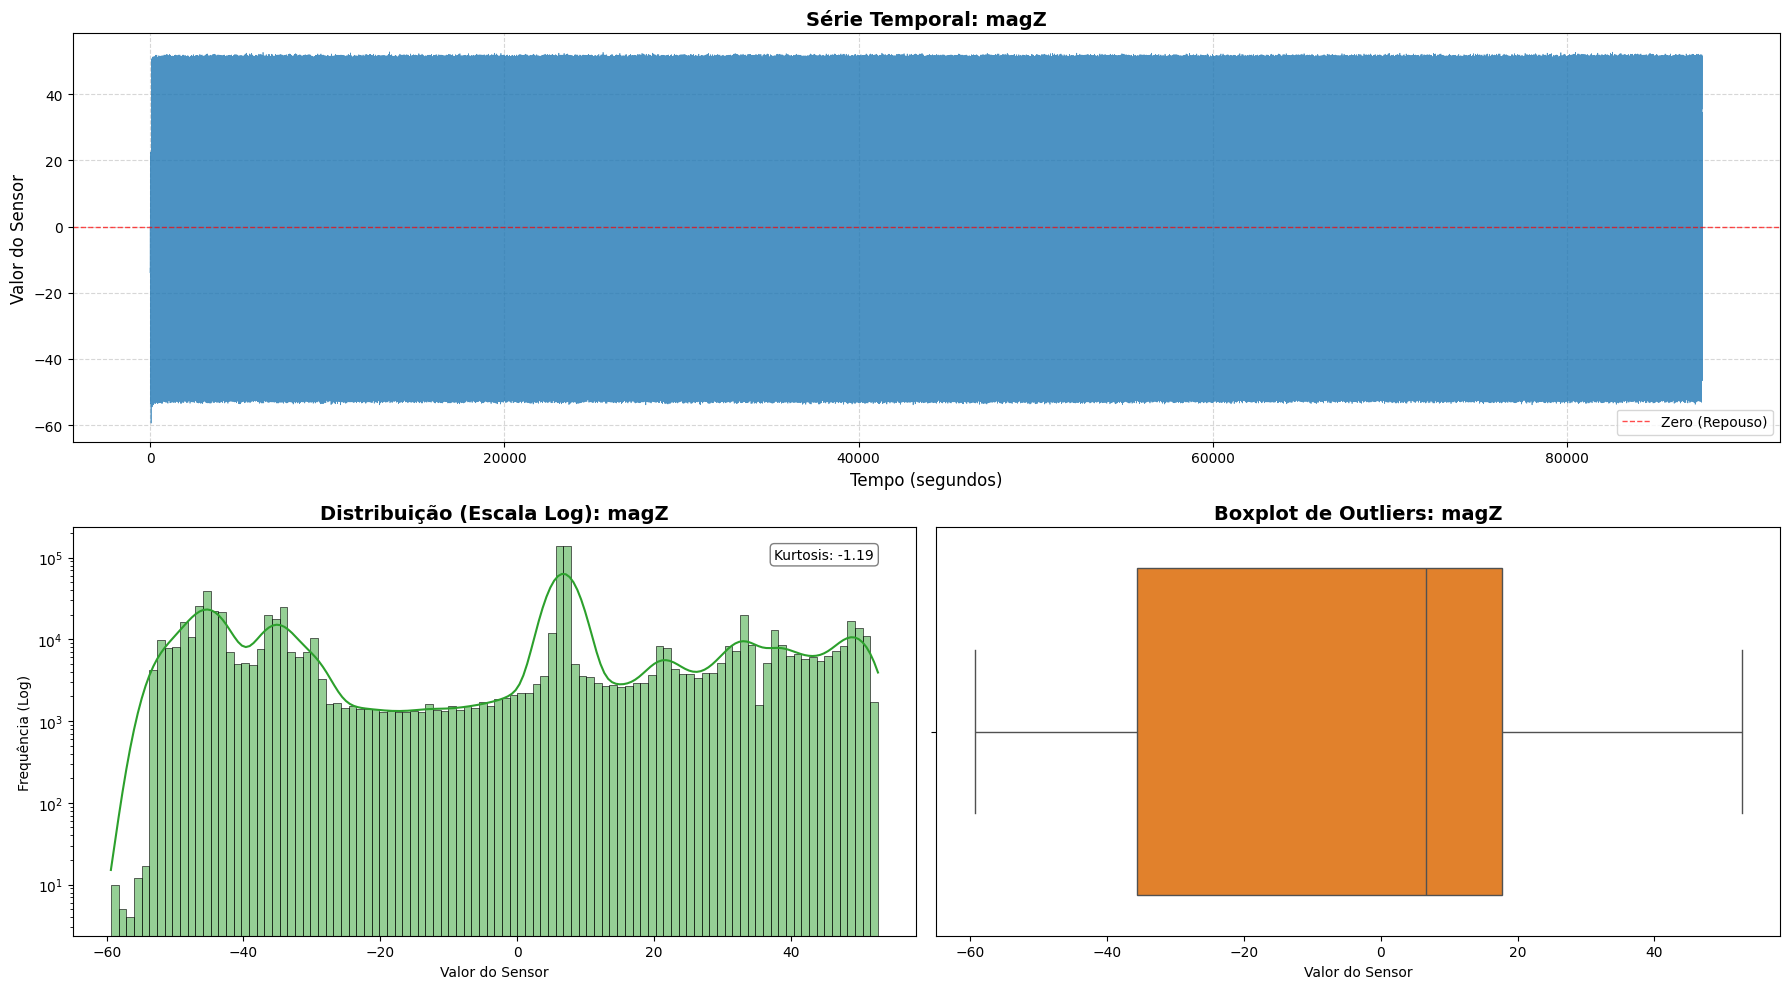

In [34]:
for sensor in sensores[6:9]:
  plot_sensor(df, col_sensor=sensor)

- O boxplot mostra que não deve-se remover os outliers pela regra de desvio padrão (3-sigma), pois serão apagados o movimento do robô sobrando só o ruído dele parado

## Análise Exploratória Estrutural [Classe Anômala]
- Informações básicas do dataset
- Tipos de dados
- Informações detalhadas
- Estatísticas descritivas
- Análise de valores únicos

In [35]:
faultydf.sample(5)

name          time      accX      accY      accZ    gyroX   gyroY  \
32853  IMU23  1.695913e+12  9.662998 -0.047884  0.203507 -53.1875  2.1250   
25979  IMU20  1.695905e+12  9.892841  0.265756 -0.900220  32.0625  0.5000   
29431  IMU23  1.695913e+12  9.284714  3.117250  0.172383  -1.8750 -0.6875   
48419  IMU22  1.695909e+12  9.691729  0.083797 -0.895431  -9.5625  0.4375   
9607   IMU21  1.695907e+12  9.804255  0.064643  0.217872   0.0625  0.2500   

        gyroZ       magX       magY       magZ  label  \
32853 -2.7500 -34.599998  30.280001  35.230770      1   
25979  2.1250 -38.160000  -6.240000  53.384617      1   
29431  0.5000 -44.560001  16.559999   6.769231      1   
48419 -0.7500 -38.840000 -17.680000  40.923077      1   
9607   0.0625 -35.560001  30.600000   8.615385      1   

                       scenario  
32853      IMU_extra_weigth.csv  
25979       IMU_hitting_arm.csv  
29431      IMU_extra_weigth.csv  
48419        IMU_earthquake.csv  
9607   IMU_hitting_platform.csv

In [36]:
faultydf['scenario'].value_counts()
vc = faultydf['scenario'].value_counts()
prop = faultydf['scenario'].value_counts(normalize=True)

pd.DataFrame({
    'count': vc,
    'proportion': prop,
    'percent': prop * 100
})


count  proportion    percent
scenario                                              
IMU_hitting_platform.csv  14967    0.304300  30.430009
IMU_hitting_arm.csv       11924    0.242432  24.243164
IMU_earthquake.csv        11409    0.231961  23.196096
IMU_extra_weigth.csv      10885    0.221307  22.130731

### Analisando por tipo de anomalia

In [37]:
dict_scenarios = {df['scenario'].iloc[0] : df for df in lista_dfs}
print(dict_scenarios.keys())

dict_keys(['IMU_hitting_platform.csv', 'IMU_hitting_arm.csv', 'IMU_extra_weigth.csv', 'IMU_earthquake.csv'])


- Removendo a coluna `name` pois não agrega valor preditivo

In [38]:
# faultydf = faultydf.drop(columns=['name', 'scenario'])

cols_to_drop = ['name', 'scenario']

for scenario_name in dict_scenarios:
  dict_scenarios[scenario_name] = dict_scenarios[scenario_name].drop(columns=cols_to_drop)
  dict_scenarios[scenario_name]['time'] = (dict_scenarios[scenario_name]['time'].map(lambda x: x/1e6))


- Verificando duplicatas

In [39]:
# print(f"[Anômalos] Duplicatas de Tempo: {faultydf['time'].duplicated().any()}")

for scenario_name in dict_scenarios:
  print(f"[{scenario_name}] duplicatas de tempo: {dict_scenarios[scenario_name]['time'].duplicated().any()}")

[IMU_hitting_platform.csv] duplicatas de tempo: False
[IMU_hitting_arm.csv] duplicatas de tempo: False
[IMU_extra_weigth.csv] duplicatas de tempo: False
[IMU_earthquake.csv] duplicatas de tempo: False


In [40]:
faultydf.info()
faultydf.memory_usage(deep=True).sum() / 1024**2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49185 entries, 0 to 49184
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      49185 non-null  object 
 1   time      49185 non-null  float64
 2   accX      49185 non-null  float64
 3   accY      49185 non-null  float64
 4   accZ      49185 non-null  float64
 5   gyroX     49185 non-null  float64
 6   gyroY     49185 non-null  float64
 7   gyroZ     49185 non-null  float64
 8   magX      49185 non-null  float64
 9   magY      49185 non-null  float64
 10  magZ      49185 non-null  float64
 11  label     49185 non-null  int64  
 12  scenario  49185 non-null  object 
dtypes: float64(10), int64(1), object(2)
memory usage: 4.9+ MB


9.921353340148926

In [41]:
for scenario_name in dict_scenarios:
  print(f"\n-------Análise Estrutural dos Sensores em {scenario_name}-------")
  analise_estrutural_sensores(dict_scenarios[scenario_name])


-------Análise Estrutural dos Sensores em IMU_hitting_platform.csv-------
1. INFORMAÇÕES BÁSICAS E TIPOS DE DADOS
Dimensões do Dataset: 14967 linhas, 11 colunas

Tipos de Dados (Dtypes):
time     float64
accX     float64
accY     float64
accZ     float64
gyroX    float64
gyroY    float64
gyroZ    float64
magX     float64
magY     float64
magZ     float64
label      int64
dtype: object

Uso de Memória: 1.26 MB

2. ANÁLISE DE INTEGRIDADE TEMPORAL (CRÍTICO PARA IMU)
- Intervalo de Amostragem Médio (Sampling Rate): 100.167379 ms
- Frequência de coleta de dados: 9.98 Hz
- Jitter (Desvio Padrão do tempo): 22.796408 ms
- Gap Mínimo: 3.999512 ms | Gap Máximo: 244.000000 ms
- Qtd. de Gaps Temporais Significativos (> 2x média): 5

3. ANÁLISE DE VALORES ÚNICOS E CONSTANTES (SENSOR FREEZE)


Tipo  Qtd_Unicos  Unicos (%)  Qtd_Zeros  Zeros (%)
magX   float64         847    5.659117          0   0.000000
gyroY  float64         926    6.186945       2394  15.995189
accZ   float64        1084    7.242600        377   2.518875
magZ   float64        1329    8.879535          5   0.033407
magY   float64        1872   12.507517          4   0.026725
gyroX  float64        2265   15.133293       1913  12.781453
gyroZ  float64        2323   15.520812       1875  12.527561
accX   float64        2436   16.275807          0   0.000000
accY   float64        4275   28.562838        177   1.182602


[OK] Nenhuma coluna totalmente constante detectada.

4. ESTATÍSTICAS DESCRITIVAS DETALHADAS (MOMENTOS)


mean        std         min        50%         max  skewness  \
accX    9.199543   1.541021   -2.030283   9.797073   16.792931 -2.775269   
accY   -0.669956   3.097713  -13.283031  -0.033519   10.915165 -0.756833   
accZ    0.017994   0.433857   -6.789956   0.011971    7.807492 -0.723081   
gyroX   0.302470  28.027220  -82.250000   0.000000   98.125000  0.471882   
gyroY   0.665735   7.975330  -27.625000   0.000000   52.312500  2.838641   
gyroZ   0.001491  26.335170 -103.062500  -0.062500  115.375000  0.456485   
magX  -33.840692   5.699663  -44.599998 -35.200001   -9.000000  1.770685   
magY   19.945876  19.297716  -49.360001  29.879999   41.840000 -1.704164   
magZ   -0.521362  31.802766  -51.538460   8.230769   56.384617 -0.090894   

        kurtosis  
accX    8.586618  
accY    1.914286  
accZ   60.518338  
gyroX   2.397976  
gyroY  17.263658  
gyroZ   4.473773  
magX    3.682838  
magY    2.158630  
magZ   -1.168817


5. BALANCEAMENTO DAS CLASSES (TARGET)
       Contagem  Percentual (%)
label                          
1         14967           100.0

Razão de Desbalanceamento: 1 : 0.0

-------Análise Estrutural dos Sensores em IMU_hitting_arm.csv-------
1. INFORMAÇÕES BÁSICAS E TIPOS DE DADOS
Dimensões do Dataset: 11924 linhas, 11 colunas

Tipos de Dados (Dtypes):
time     float64
accX     float64
accY     float64
accZ     float64
gyroX    float64
gyroY    float64
gyroZ    float64
magX     float64
magY     float64
magZ     float64
label      int64
dtype: object

Uso de Memória: 1.00 MB

2. ANÁLISE DE INTEGRIDADE TEMPORAL (CRÍTICO PARA IMU)
- Intervalo de Amostragem Médio (Sampling Rate): 100.156336 ms
- Frequência de coleta de dados: 9.98 Hz
- Jitter (Desvio Padrão do tempo): 21.728151 ms
- Gap Mínimo: 3.999512 ms | Gap Máximo: 244.000000 ms
- Qtd. de Gaps Temporais Significativos (> 2x média): 6

3. ANÁLISE DE VALORES ÚNICOS E CONSTANTES (SENSOR FREEZE)


Tipo  Qtd_Unicos  Unicos (%)  Qtd_Zeros  Zeros (%)
magX   float64         780    6.541429          0   0.000000
gyroY  float64         785    6.583361       2059  17.267695
accZ   float64         935    7.841328        446   3.740356
magZ   float64        1257   10.541765          4   0.033546
magY   float64        1727   14.483395          1   0.008386
gyroZ  float64        2036   17.074807       1816  15.229789
gyroX  float64        2042   17.125126       1809  15.171084
accX   float64        2210   18.534049          0   0.000000
accY   float64        3734   31.314995         56   0.469641


[OK] Nenhuma coluna totalmente constante detectada.

4. ESTATÍSTICAS DESCRITIVAS DETALHADAS (MOMENTOS)


mean        std         min        50%         max  skewness  \
accX    9.193710   1.642343  -17.204733   9.773131   22.917297 -3.378236   
accY   -0.358373   3.082262  -17.556681   0.234632    9.296685 -0.818818   
accZ    0.015740   0.427035   -9.806650   0.014365    9.828197 -0.170223   
gyroX   0.253129  26.640458  -82.250000   0.000000   98.187500  0.503436   
gyroY   0.536544   7.595412  -27.562500   0.000000   52.187500  2.980701   
gyroZ   0.004020  25.121952 -102.812500   0.000000  113.937500  0.481771   
magX  -33.531322   5.696119  -43.680000 -34.880001   -9.640000  1.556350   
magY   20.016602  19.206307  -48.599998  29.959999   41.520000 -1.642177   
magZ   -1.543990  32.817725  -51.846153   8.230769   57.153847 -0.045428   

         kurtosis  
accX    26.192922  
accY     1.922733  
accZ   107.681845  
gyroX    2.974726  
gyroY   19.344244  
gyroZ    5.178473  
magX     3.230196  
magY     1.981464  
magZ    -1.198222


5. BALANCEAMENTO DAS CLASSES (TARGET)
       Contagem  Percentual (%)
label                          
1         11924           100.0

Razão de Desbalanceamento: 1 : 0.0

-------Análise Estrutural dos Sensores em IMU_extra_weigth.csv-------
1. INFORMAÇÕES BÁSICAS E TIPOS DE DADOS
Dimensões do Dataset: 10885 linhas, 11 colunas

Tipos de Dados (Dtypes):
time     float64
accX     float64
accY     float64
accZ     float64
gyroX    float64
gyroY    float64
gyroZ    float64
magX     float64
magY     float64
magZ     float64
label      int64
dtype: object

Uso de Memória: 0.91 MB

2. ANÁLISE DE INTEGRIDADE TEMPORAL (CRÍTICO PARA IMU)
- Intervalo de Amostragem Médio (Sampling Rate): 100.158765 ms
- Frequência de coleta de dados: 9.98 Hz
- Jitter (Desvio Padrão do tempo): 23.784932 ms
- Gap Mínimo: 3.000244 ms | Gap Máximo: 247.000244 ms
- Qtd. de Gaps Temporais Significativos (> 2x média): 5

3. ANÁLISE DE VALORES ÚNICOS E CONSTANTES (SENSOR FREEZE)


Tipo  Qtd_Unicos  Unicos (%)  Qtd_Zeros  Zeros (%)
accZ   float64         591    5.429490        287   2.636656
magX   float64         790    7.257694          1   0.009187
gyroY  float64         801    7.358751       2129  19.559026
magZ   float64        1202   11.042719          4   0.036748
magY   float64        1694   15.562701         15   0.137804
accX   float64        2003   18.401470          0   0.000000
gyroZ  float64        2031   18.658705       1405  12.907671
gyroX  float64        2041   18.750574       1329  12.209463
accY   float64        3429   31.502067        152   1.396417


[OK] Nenhuma coluna totalmente constante detectada.

4. ESTATÍSTICAS DESCRITIVAS DETALHADAS (MOMENTOS)


mean        std         min        50%         max  skewness  \
accX    9.204861   1.497229    1.175553   9.804255   11.322180 -2.806220   
accY   -0.667537   3.054883   -9.830592  -0.031125    8.118738 -0.789692   
accZ    0.028303   0.207384   -0.969652   0.019154    0.960075 -0.012192   
gyroX   0.307166  27.886882  -81.937500   0.000000   97.500000  0.478474   
gyroY   0.616381   7.937545  -27.250000   0.000000   52.812500  2.890914   
gyroZ   0.016537  26.193308 -103.312500  -0.062500  113.937500  0.453724   
magX  -34.725023   5.641419  -45.000000 -36.400002    0.000000  1.855170   
magY   19.415530  18.971149  -49.040001  29.559999   40.560001 -1.736453   
magZ   -0.618487  30.554599  -48.307693   7.692307   53.461540 -0.067026   

        kurtosis  
accX    8.160344  
accY    1.965755  
accZ    1.704703  
gyroX   2.457102  
gyroY  17.610494  
gyroZ   4.552873  
magX    4.099539  
magY    2.319105  
magZ   -1.137919


5. BALANCEAMENTO DAS CLASSES (TARGET)
       Contagem  Percentual (%)
label                          
1         10885           100.0

Razão de Desbalanceamento: 1 : 0.0

-------Análise Estrutural dos Sensores em IMU_earthquake.csv-------
1. INFORMAÇÕES BÁSICAS E TIPOS DE DADOS
Dimensões do Dataset: 11409 linhas, 11 colunas

Tipos de Dados (Dtypes):
time     float64
accX     float64
accY     float64
accZ     float64
gyroX    float64
gyroY    float64
gyroZ    float64
magX     float64
magY     float64
magZ     float64
label      int64
dtype: object

Uso de Memória: 0.96 MB

2. ANÁLISE DE INTEGRIDADE TEMPORAL (CRÍTICO PARA IMU)
- Intervalo de Amostragem Médio (Sampling Rate): 100.165060 ms
- Frequência de coleta de dados: 9.98 Hz
- Jitter (Desvio Padrão do tempo): 21.891069 ms
- Gap Mínimo: 4.000000 ms | Gap Máximo: 244.000000 ms
- Qtd. de Gaps Temporais Significativos (> 2x média): 10

3. ANÁLISE DE VALORES ÚNICOS E CONSTANTES (SENSOR FREEZE)


Tipo  Qtd_Unicos  Unicos (%)  Qtd_Zeros  Zeros (%)
magX   float64         789    6.915593          1   0.008765
gyroY  float64         826    7.239898        980   8.589710
magZ   float64        1198   10.500482          2   0.017530
magY   float64        1716   15.040757          7   0.061355
gyroZ  float64        2083   18.257516        475   4.163380
gyroX  float64        2103   18.432816        432   3.786484
accZ   float64        2140   18.757122         40   0.350600
accX   float64        2162   18.949952          0   0.000000
accY   float64        4150   36.374792         46   0.403190


[OK] Nenhuma coluna totalmente constante detectada.

4. ESTATÍSTICAS DESCRITIVAS DETALHADAS (MOMENTOS)


mean        std         min        50%         max  skewness  \
accX    9.196923   1.594981   -1.989582   9.727641   12.164939 -2.897943   
accY   -0.671508   3.189479  -10.608707  -0.119710    8.906430 -0.693511   
accZ    0.028485   1.155177   -4.122815   0.038307    3.356671 -0.127315   
gyroX   0.424572  28.002069  -82.312500   0.062500   99.000000  0.475134   
gyroY   0.591852   7.978060  -27.875000   0.000000   52.250000  2.855406   
gyroZ   0.064023  26.309701 -104.250000  -0.125000  113.500000  0.451461   
magX  -34.642048   5.659721  -44.919998 -36.360001    0.000000  1.845347   
magY   19.421492  19.015040  -49.080002  29.639999   40.599998 -1.725380   
magZ   -0.655434  30.615335  -48.230770   7.692307   53.461540 -0.060619   

        kurtosis  
accX    9.345403  
accY    1.663731  
accZ   -0.431534  
gyroX   2.418532  
gyroY  17.368413  
gyroZ   4.496520  
magX    4.031058  
magY    2.275337  
magZ   -1.147510


5. BALANCEAMENTO DAS CLASSES (TARGET)
       Contagem  Percentual (%)
label                          
1         11409           100.0

Razão de Desbalanceamento: 1 : 0.0


### Análise de Integridade Temporal
- Tamanho: desbalanceamento entre os dados normais e anômalos, enquanto que df possui	~875.000 linhas, faultydf tem ~15.000 linhas.
- Sampling Rate Médio: A frequência de coleta é a mesma no estado normal e de falha. `Sendo necessário resampling para 100ms e interpolate em ambos os conjuntos.` 
- Jitter (Desvio Padrão): Ambos têm um jitter significativo (~20ms).
- Gaps: O dataset normal tem uma quantidade muito maior de gaps de tempo 5 em relação a 429. `Ignorar Gaps como Feature de Anomalia`. Resample e interpolate é essencial para preencher esses gaps e garantir que a série temporal seja contínua para o Autoencoder ou modelos de janela deslizante sem introduzir o viés da falha de coleta.
- Gap Máximo: O maior gap está no dataset normal.

### Análise de valores únicos e constantes
- `accZ` é o ponto mais divergente e provavelmente a melhor feature física para detecção. Em relação aos dados normais, existe um aumento de 35x na ocorrência de zeros
- A proporção de valores únicos em `accY` é possível confirmar que a falha não é apenas parar, mas sim um comportamento dinâmico e irregular.
- `magX` e `magZ` têm poucos valores únicos em relação aos outros sensores, parecem sensores com baixa sensibilidade. Se precisar reduzir a complexidade do modelo, eles podem ser candidatos a serem removidos por Feature Selection.


- Visualizando `accZ` em diferentes anomalias


-----------IMU_hitting_platform.csv-----------


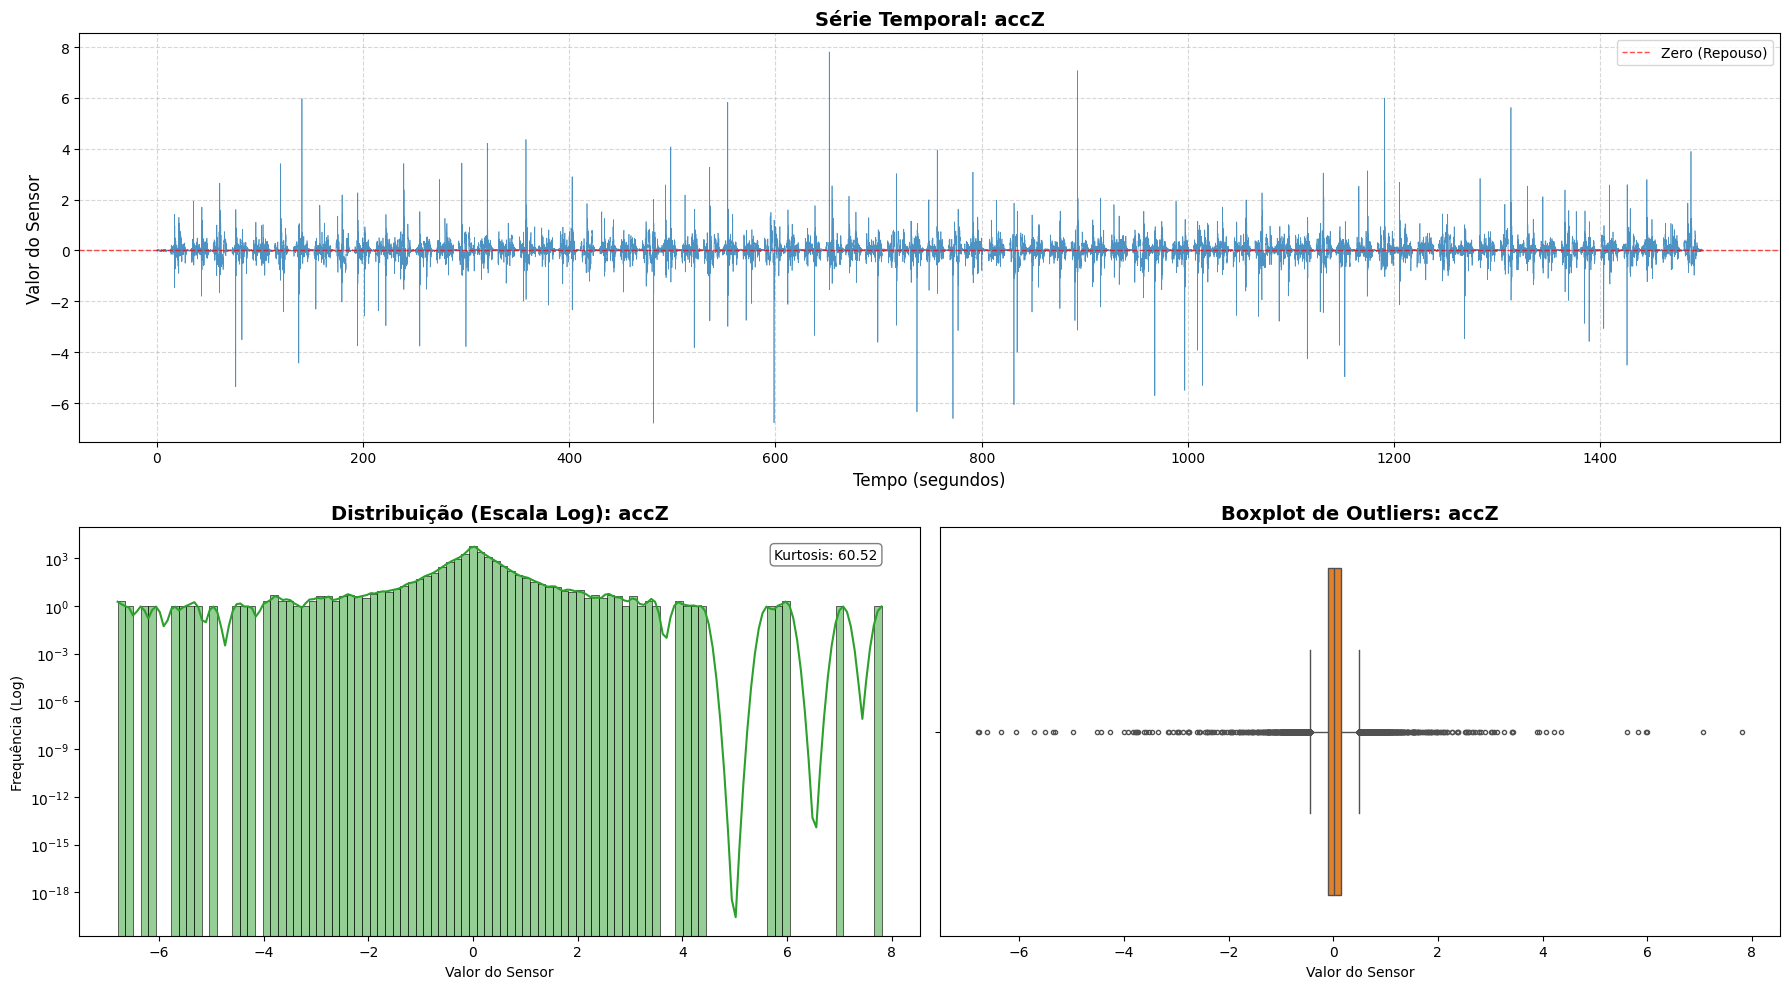


-----------IMU_hitting_arm.csv-----------


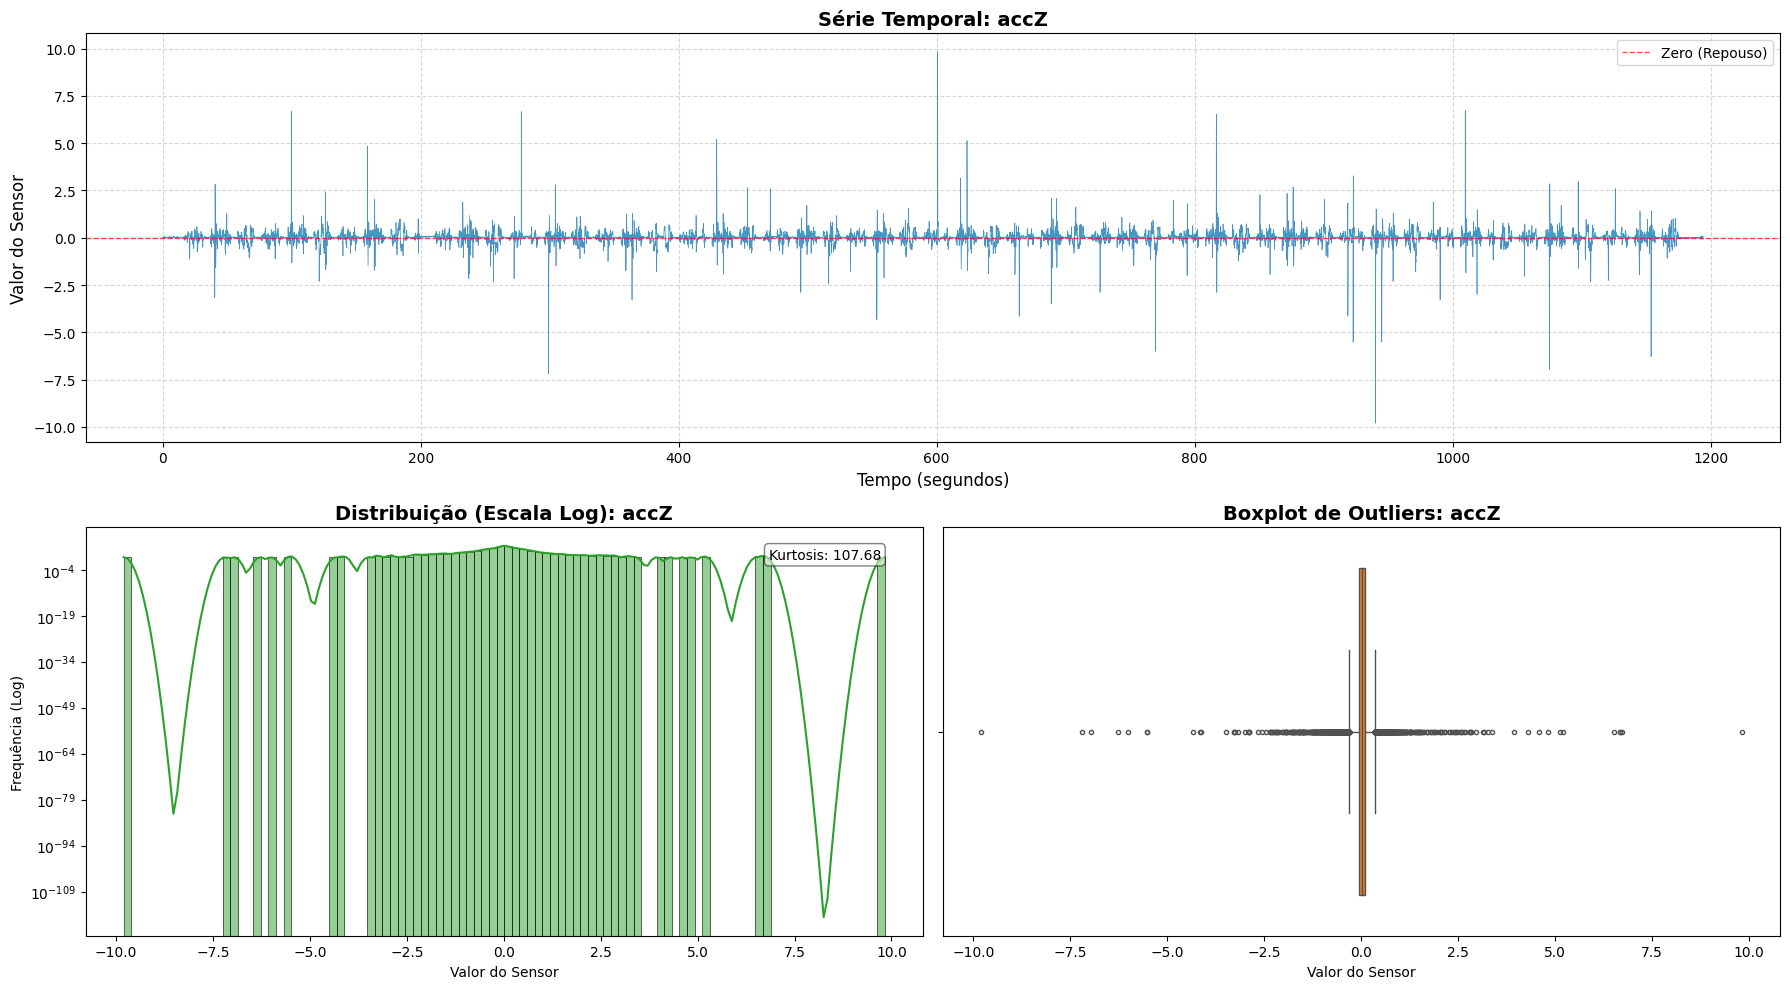


-----------IMU_extra_weigth.csv-----------


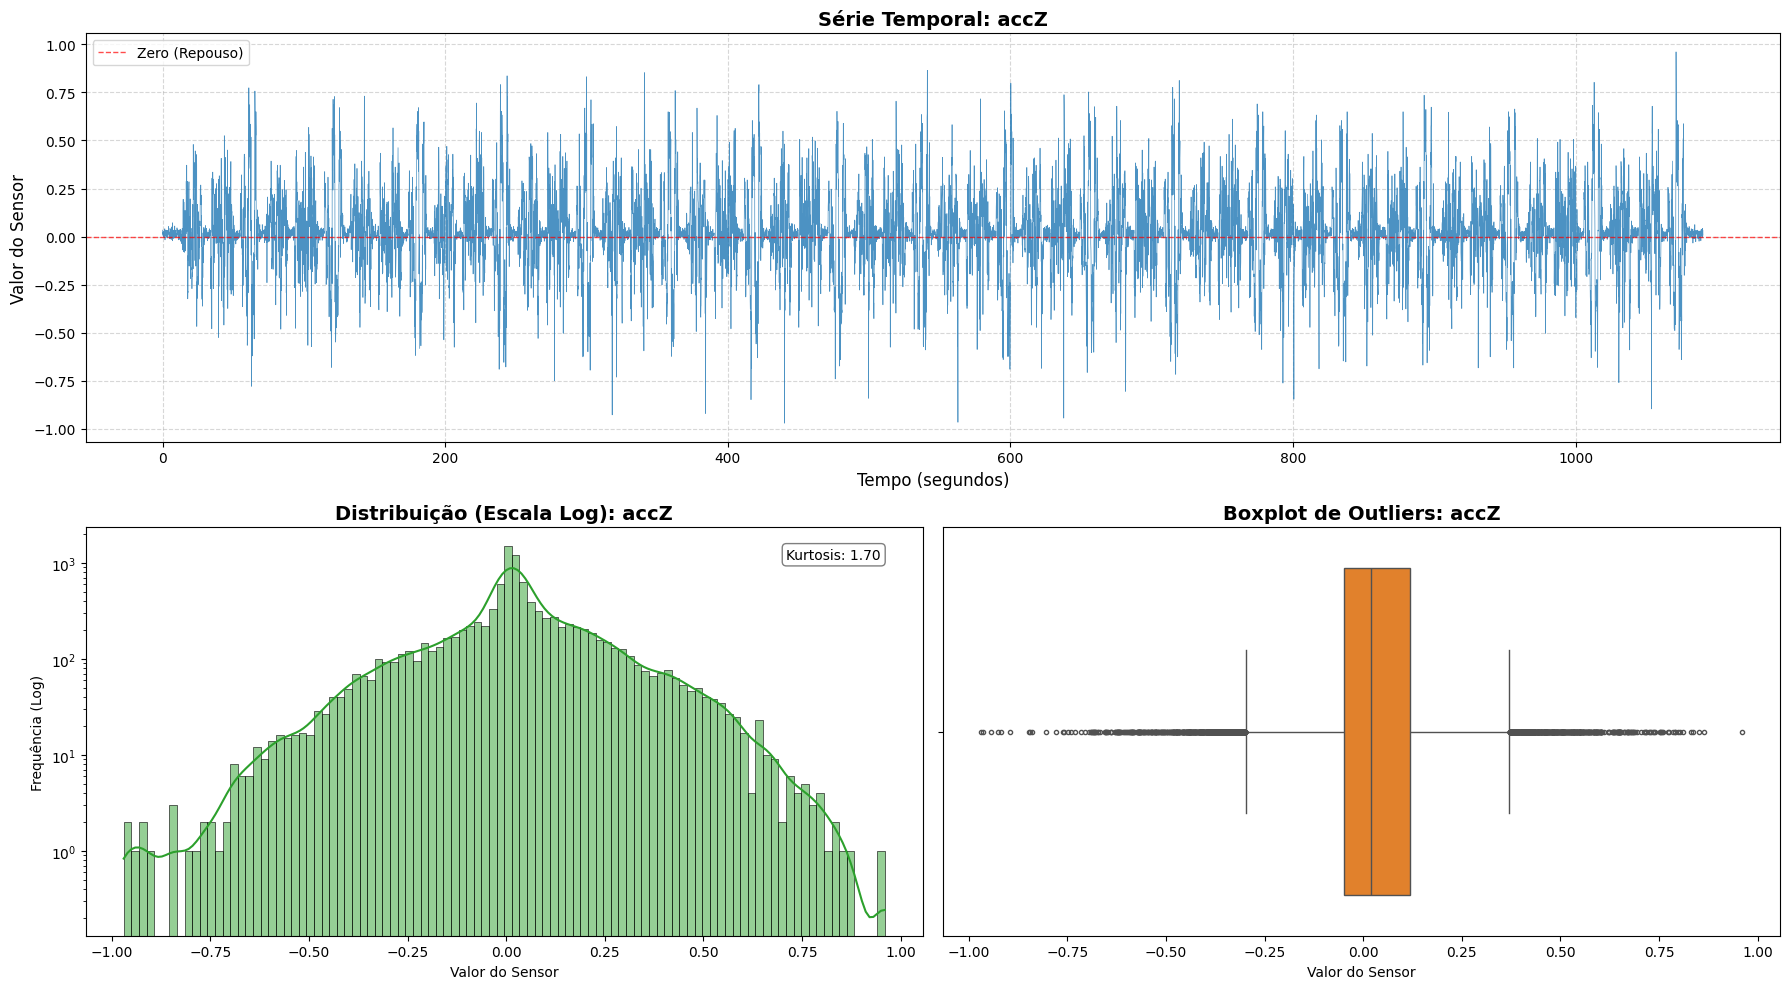


-----------IMU_earthquake.csv-----------


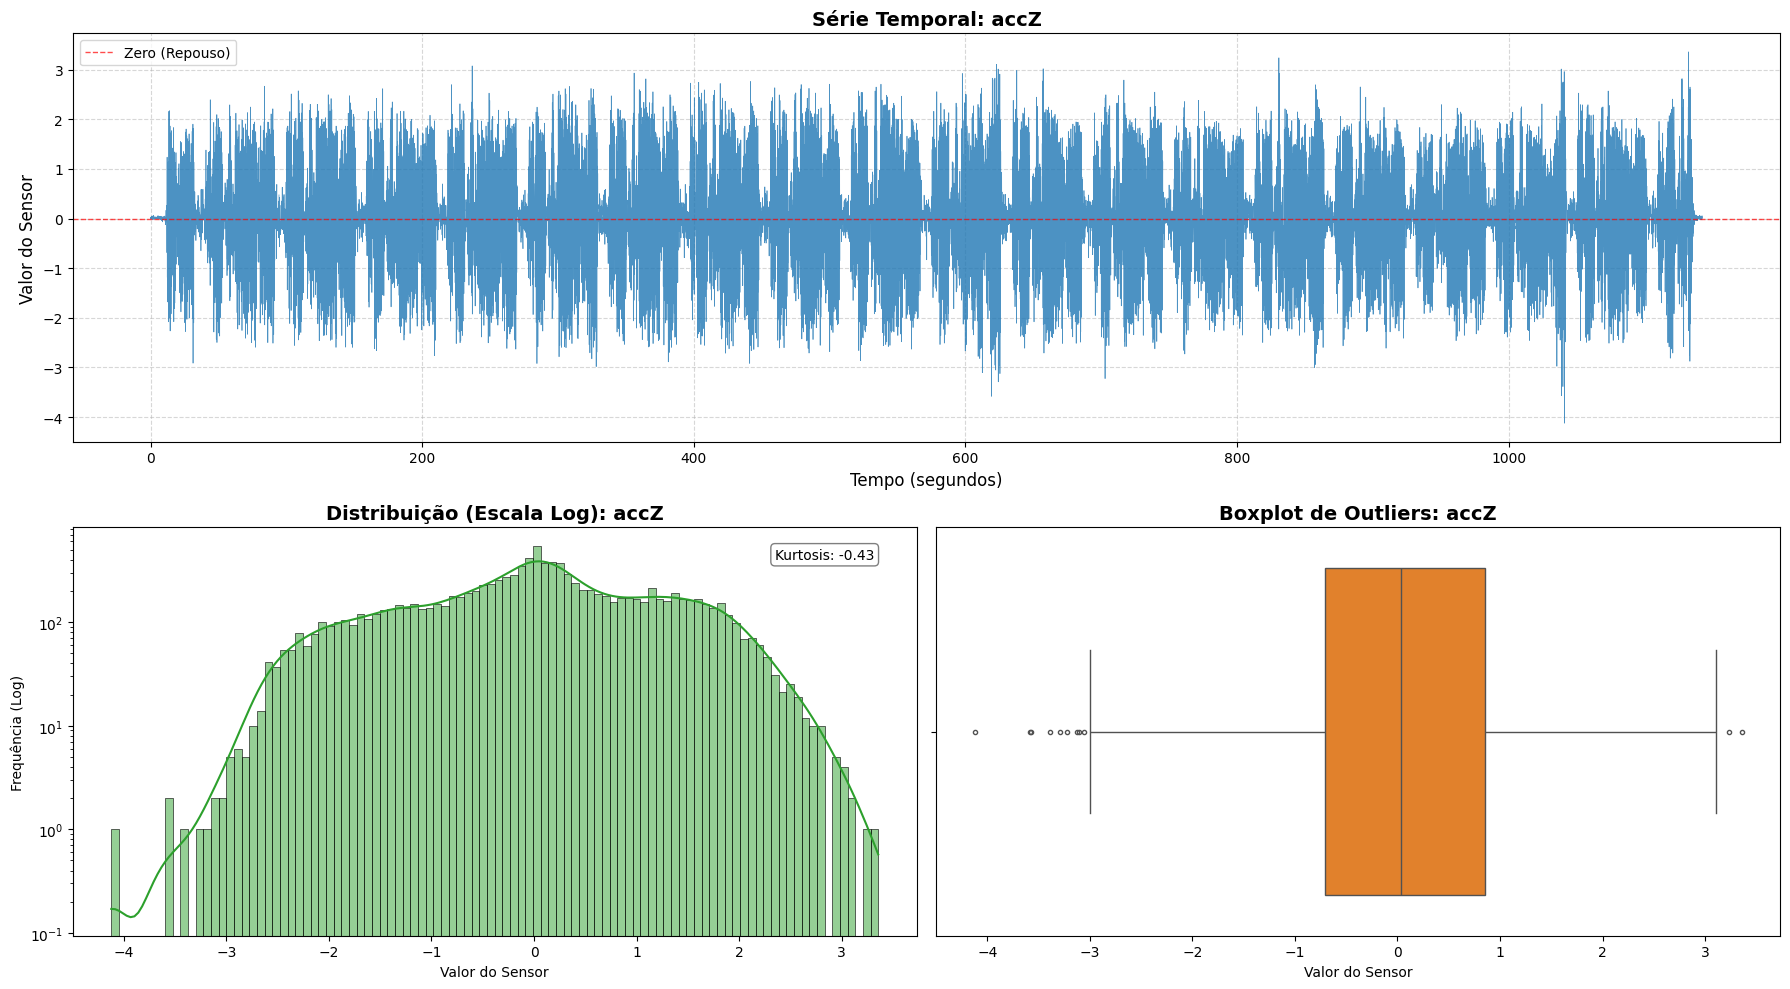

In [42]:
for scenario_name in dict_scenarios:
  print(f"\n-----------{scenario_name}-----------")
  plot_sensor(dict_scenarios[scenario_name], col_sensor='accZ')

- Comparando normal vs. falha

In [43]:
def comparar_normal_vs_falha(df_normal, df_falha, col_sensor, anomalia):
    """
    Plota comparativo visual entre operação Normal e Falha (Ataque/Colisão).
    """
    # 1. Ajuste de Tempo (reseta para começar do zero em ambos para facilitar visualização)
    t_norm = (df_normal['time'] - df_normal['time'].iloc[0]) / 1e3
    t_fail = (df_falha['time'] - df_falha['time'].iloc[0]) / 1e3
    
    # Recorte: Pegar apenas os primeiros 10 segundos de cada para não poluir
    mask_norm = t_norm <= 10
    mask_fail = t_fail <= 10
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
    
    # --- PLOT 1: COMPARAÇÃO NO TEMPO ---
    # Normal
    axes[0].plot(t_norm[mask_norm], df_normal.loc[mask_norm, col_sensor], 
                 color='#1f77b4', label='Normal', alpha=0.7, linewidth=1)
    axes[0].set_title(f'Padrão Normal vs. Falha - {anomalia} ({col_sensor})', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Valor do Sensor')
    axes[0].set_xlabel('Tempo [s]')
    axes[0].legend(loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    # Falha (mesmo eixo para ver a diferença de magnitude)
    axes[0].plot(t_fail[mask_fail], df_falha.loc[mask_fail, col_sensor], 
                 color='#d62728', label='Falha', alpha=0.7, linewidth=1)
    axes[0].legend()
    
    # --- PLOT 2: COMPARAÇÃO DE DENSIDADE (KDE) ---
    # Mostra se a "forma" dos dados mudou
    sns.kdeplot(df_normal[col_sensor], ax=axes[1], color='#1f77b4', fill=True, label='Normal')
    sns.kdeplot(df_falha[col_sensor], ax=axes[1], color='#d62728', fill=True, label='Falha')
    axes[1].set_title(f'Mudança na Distribuição de Probabilidade - {anomalia}', fontsize=14, fontweight='bold')
    axes[1].set_yscale('log') # Log para ver as caudas
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if 'name' in faultydf.columns: faultydf = faultydf.drop(columns=['name'])

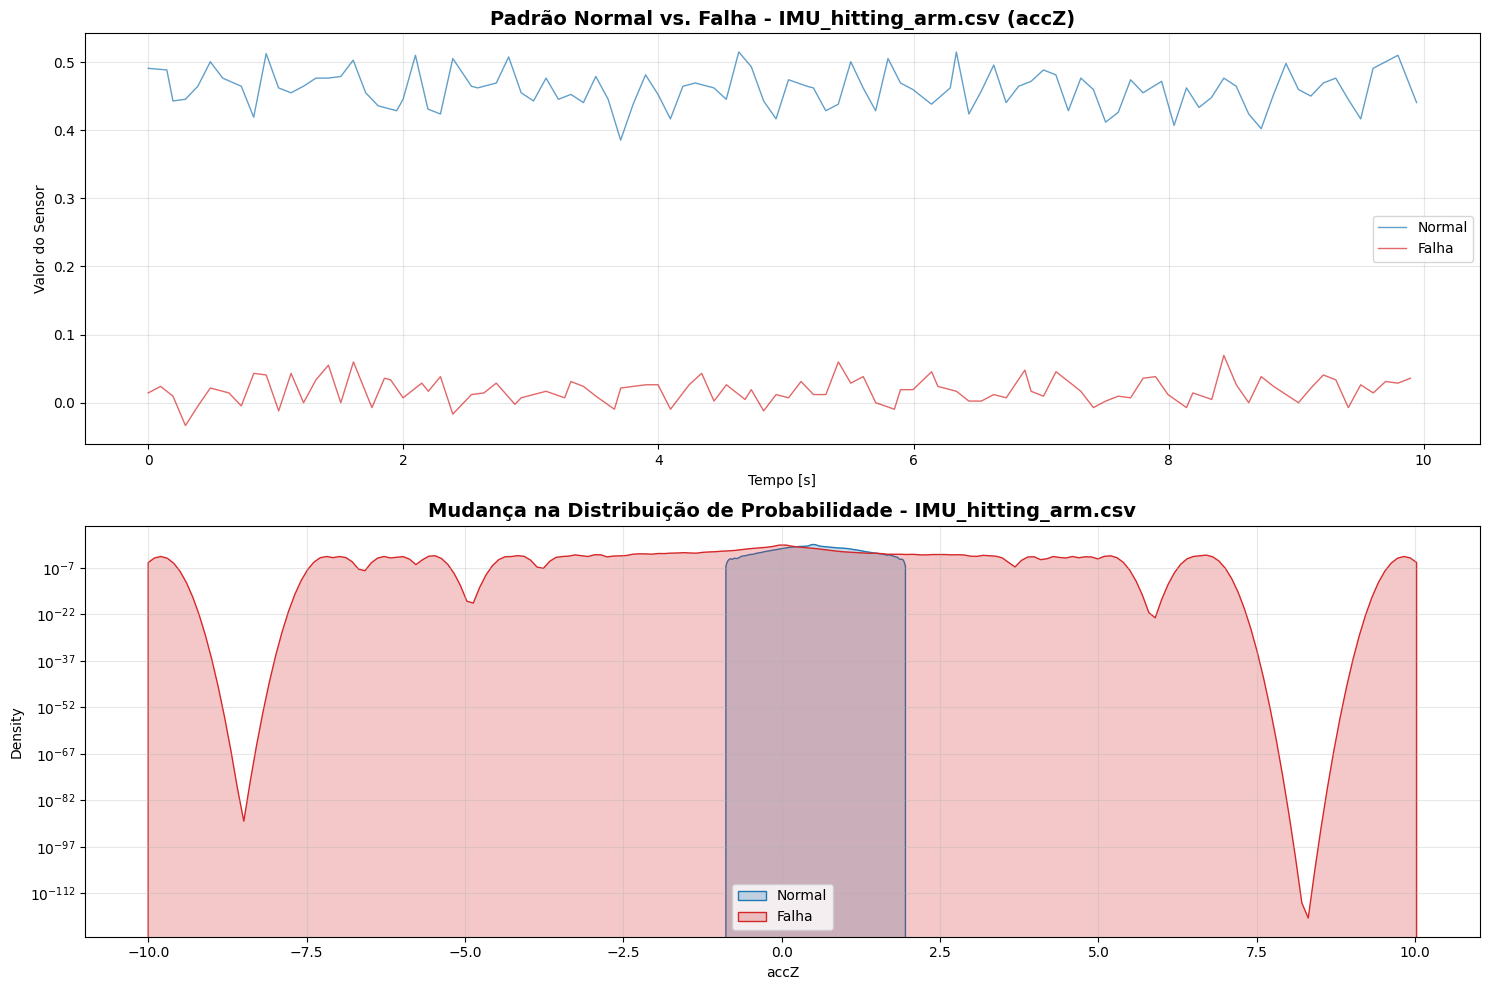

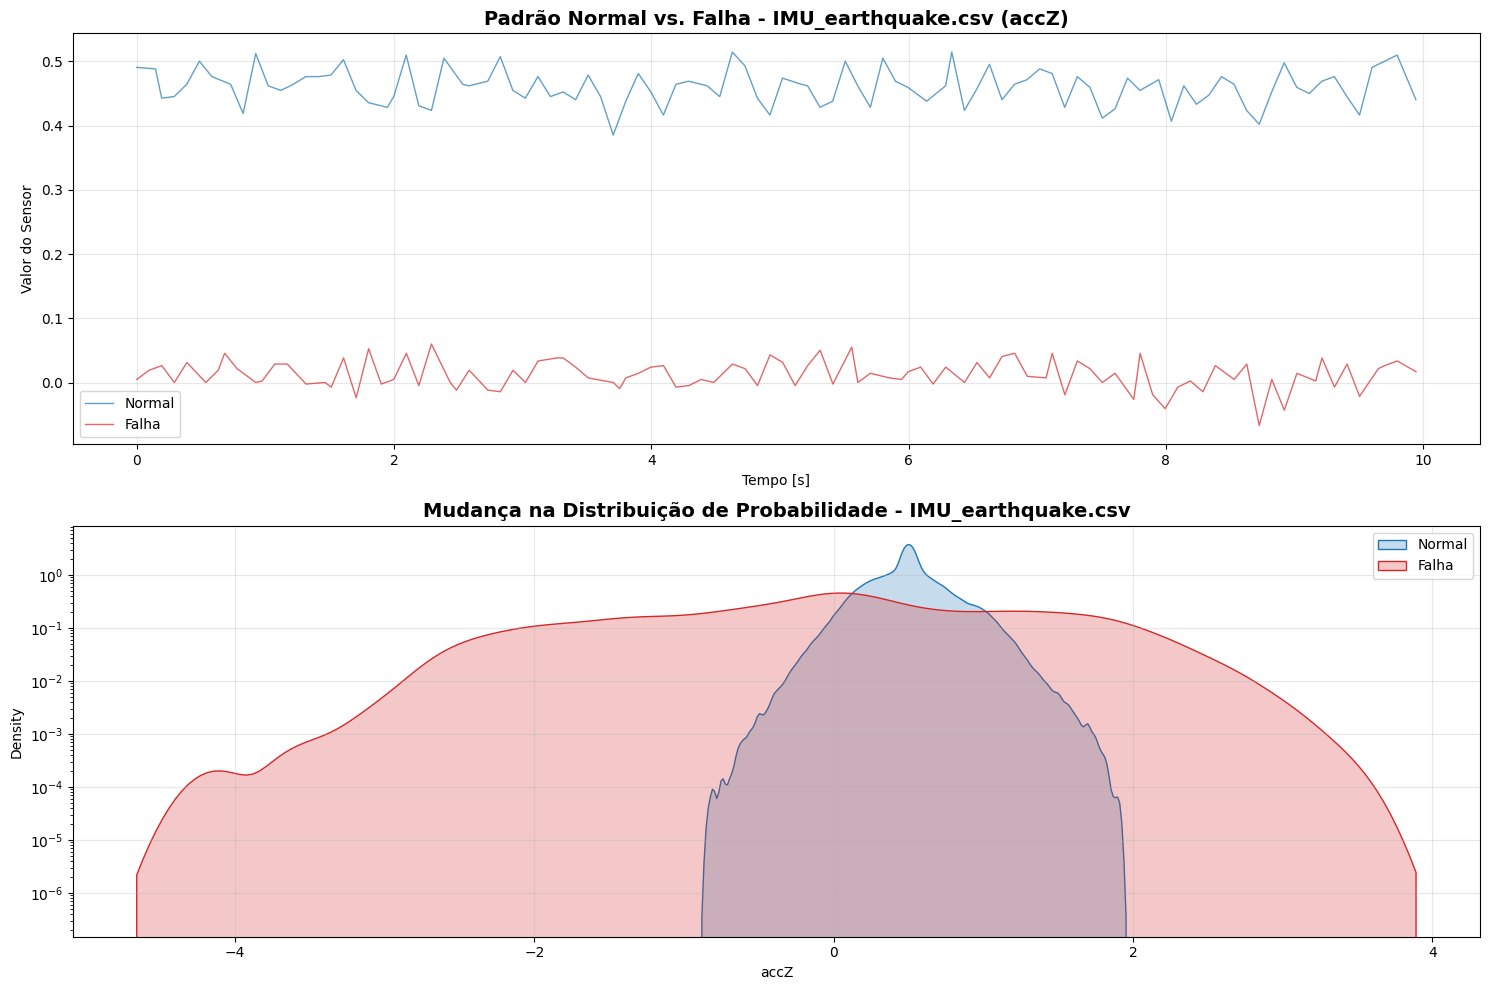

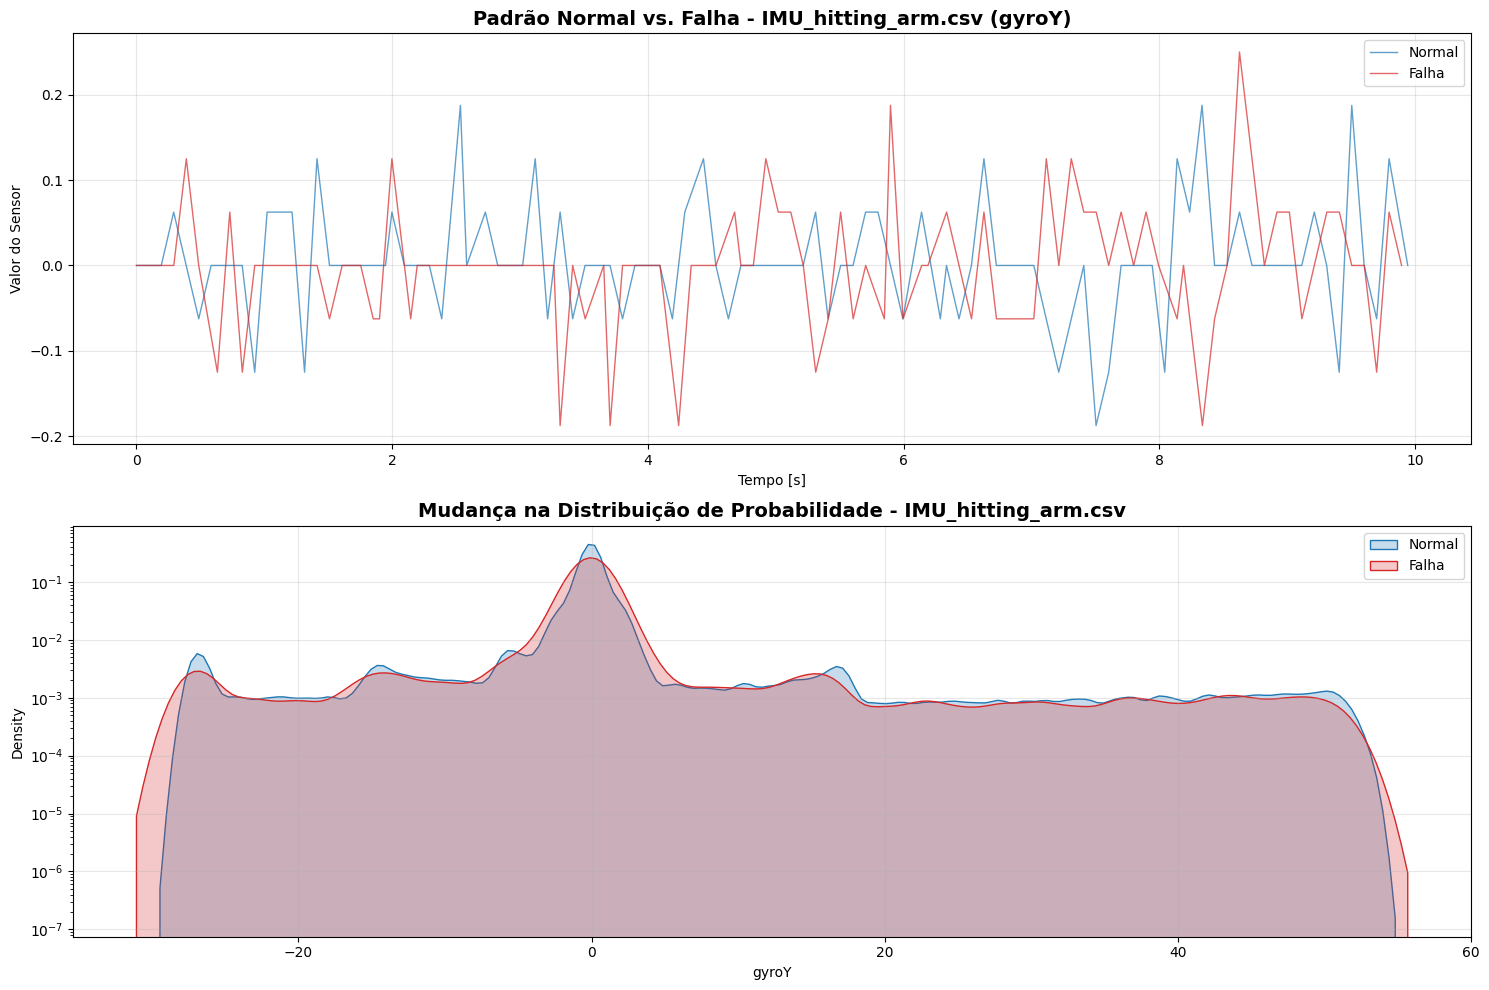

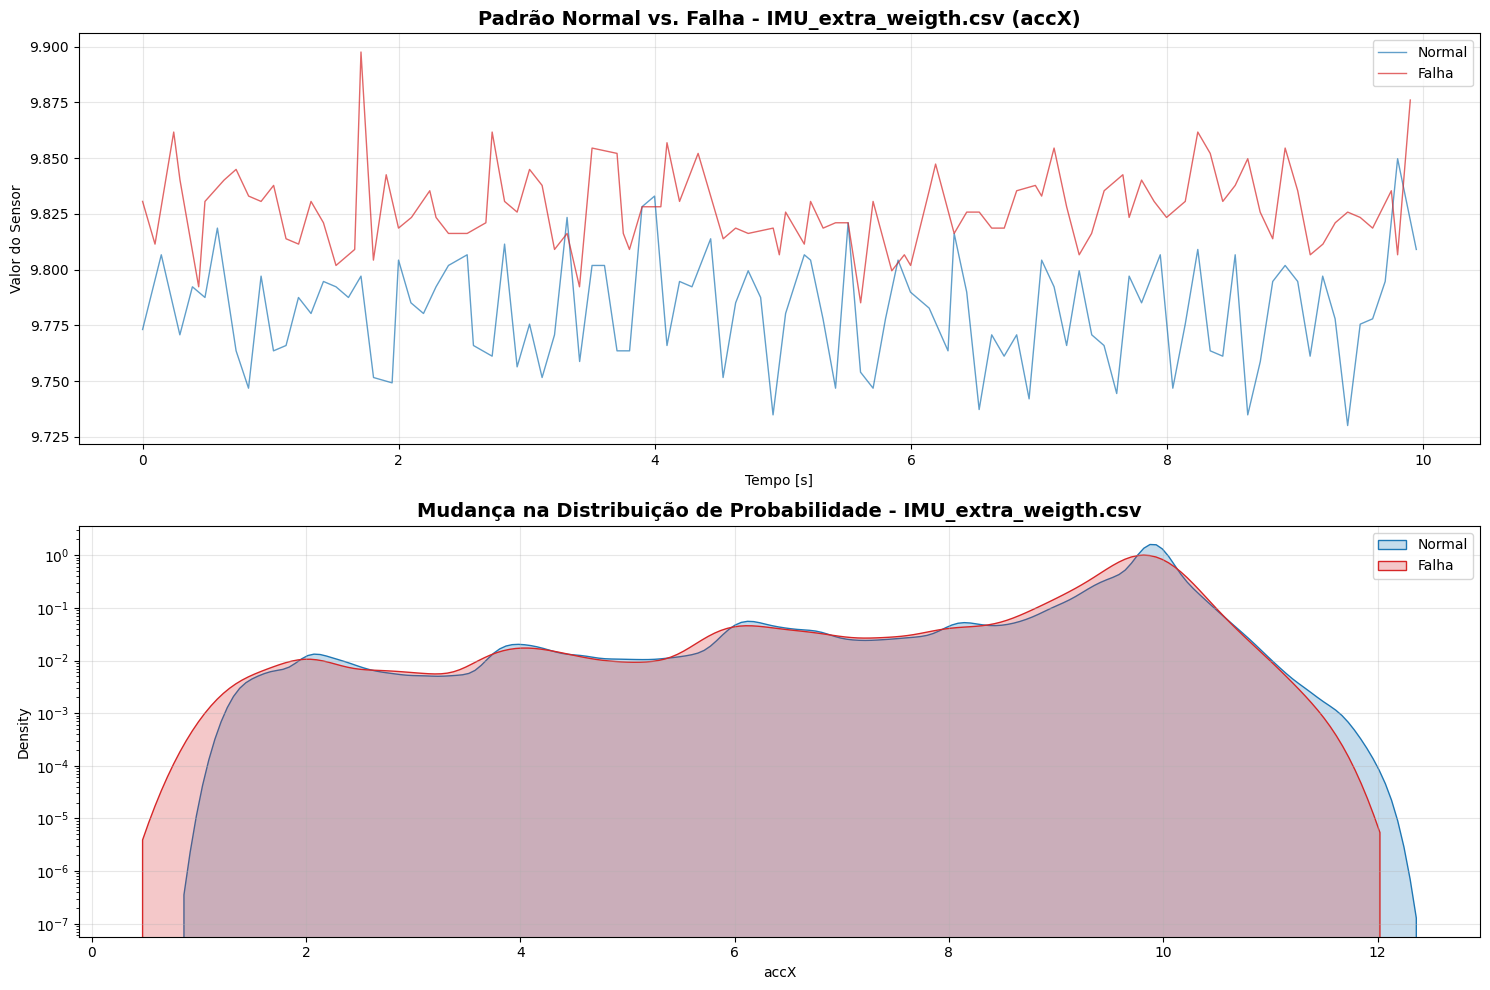

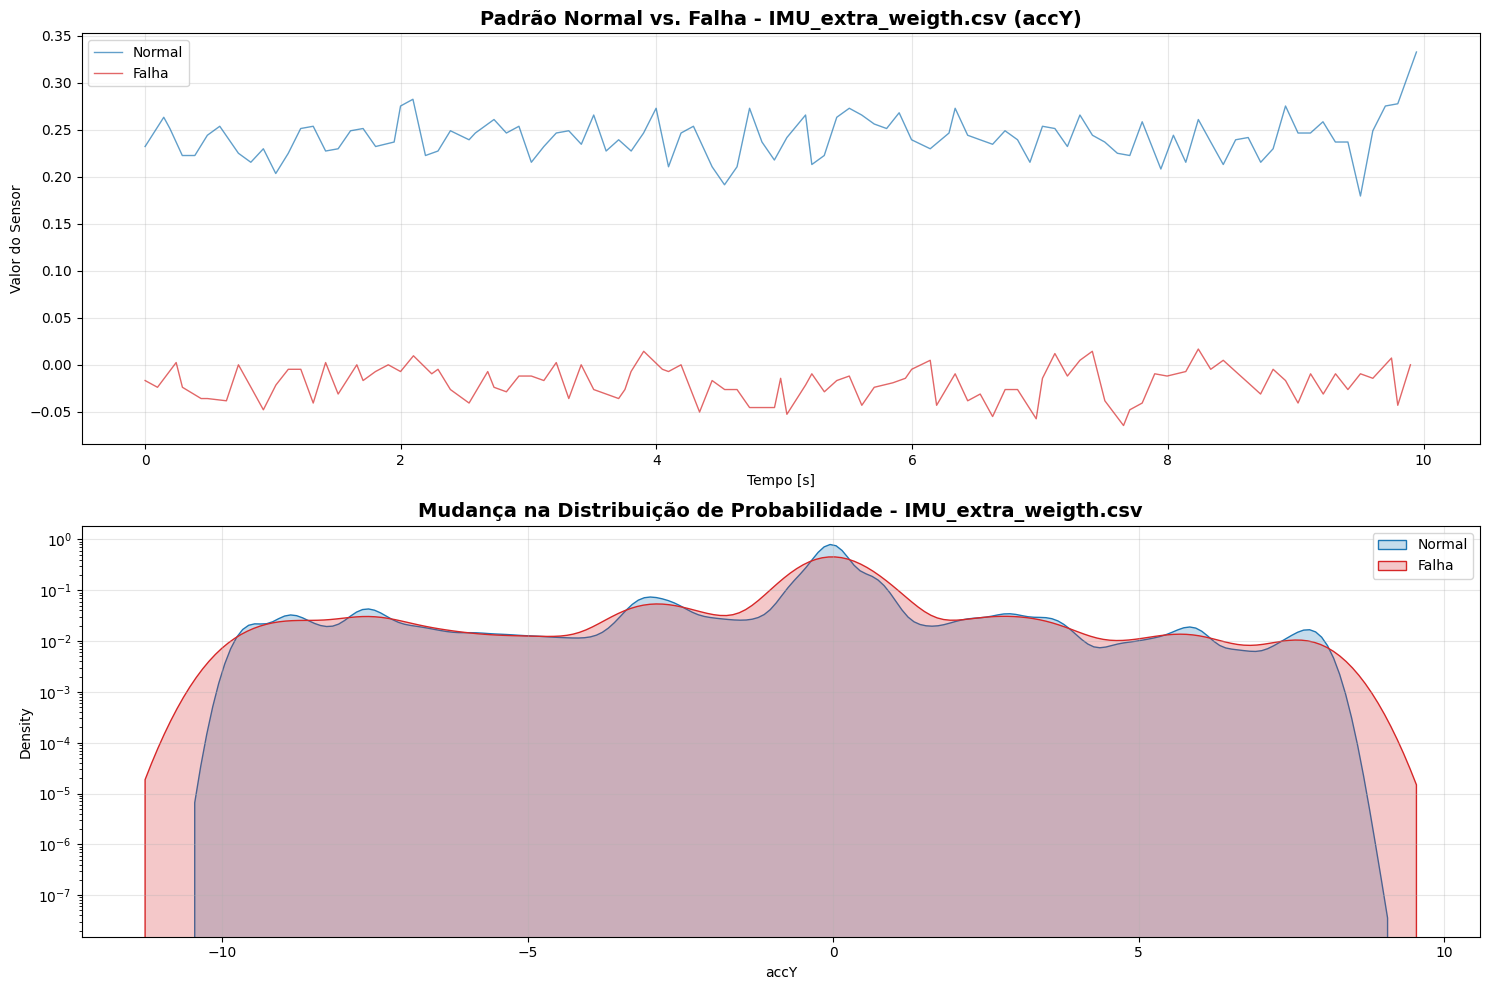

In [44]:
comparar_normal_vs_falha(df, dict_scenarios['IMU_hitting_arm.csv'], col_sensor='accZ', anomalia='IMU_hitting_arm.csv')
comparar_normal_vs_falha(df, dict_scenarios['IMU_earthquake.csv'], col_sensor='accZ', anomalia='IMU_earthquake.csv')
comparar_normal_vs_falha(df, dict_scenarios['IMU_hitting_arm.csv'], col_sensor='gyroY', anomalia='IMU_hitting_arm.csv')
comparar_normal_vs_falha(df, dict_scenarios['IMU_extra_weigth.csv'], col_sensor='accX', anomalia='IMU_extra_weigth.csv')
comparar_normal_vs_falha(df, dict_scenarios['IMU_extra_weigth.csv'], col_sensor='accY', anomalia='IMU_extra_weigth.csv')

## Análise de Valores Faltantes e Outliers
- Identificação de valores faltantes e outliers
- Visualizações de apoio, caso necessário
- Análise dos mecanismos


In [45]:
print(f"Quantidade de valores faltantes em df: {df.isnull().sum().sum()}")

for scenario_name in dict_scenarios:
  print(f"[{scenario_name}] quantidade de Valores faltantes: {dict_scenarios[scenario_name].isnull().sum().sum()}")

#print(f"Quantidade de Valores faltantes em faultydf: {faultydf.isnull().sum().sum()}")

Quantidade de valores faltantes em df: 0
[IMU_hitting_platform.csv] quantidade de Valores faltantes: 0
[IMU_hitting_arm.csv] quantidade de Valores faltantes: 0
[IMU_extra_weigth.csv] quantidade de Valores faltantes: 0
[IMU_earthquake.csv] quantidade de Valores faltantes: 0


- Não serão removidos os outliers estatísticos pois são movimentos reais

- Resampling para 100ms

In [46]:
def resampling_and_interpolate(df, df_name):
    print(f"\nFazendo Resampling e Interpolate de {df_name}")
    # 1. Converter tempo para Datetime (necessário para resampling)
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')
    df = df.set_index('datetime')

    # 2. Resampling para 100ms (10Hz) - Ajuste conforme a média que vimos
    # .mean() pega todos os pontos que caíram naquele 0.1s e tira a média (reduz ruído)
    df_resampled = df.resample('100ms').mean()

    # 3. Verificar onde ficaram os buracos (NaNs gerados pelo resampling)
    print(f"Buracos gerados pelo alinhamento: {df_resampled['accX'].isnull().sum()}")

    # 4. Preencher buracos com Interpolação Linear
    # 'time' garante que a interpolação respeite a distância temporal
    df_final = df_resampled.interpolate(method='time')

    # 5. Drop nas colunas que não fazem sentido interpolar (ex: label)
    if 'label' in df_final.columns:
        df_final['label'] = df_resampled['label'].ffill().astype(int)

    print("Resampling concluído. Novo shape:", df_final.shape)
    
    return df_final

In [47]:
df_normal_resampled = resampling_and_interpolate(df, "df")
faultydfs_resampled = {}
for name, df in dict_scenarios.items():
  faultydfs_resampled[name] = resampling_and_interpolate(df, name)

faultydf_resampled = pd.concat(faultydfs_resampled.values(), ignore_index=True)


Fazendo Resampling e Interpolate de df
Buracos gerados pelo alinhamento: 44766
Resampling concluído. Novo shape: (876347, 11)

Fazendo Resampling e Interpolate de IMU_hitting_platform.csv
Buracos gerados pelo alinhamento: 900
Resampling concluído. Novo shape: (14992, 11)

Fazendo Resampling e Interpolate de IMU_hitting_arm.csv
Buracos gerados pelo alinhamento: 676
Resampling concluído. Novo shape: (11943, 11)

Fazendo Resampling e Interpolate de IMU_extra_weigth.csv
Buracos gerados pelo alinhamento: 709
Resampling concluído. Novo shape: (10902, 11)

Fazendo Resampling e Interpolate de IMU_earthquake.csv
Buracos gerados pelo alinhamento: 638
Resampling concluído. Novo shape: (11428, 11)


- Normalização com RobustScaler e StandardScaler

In [48]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

scaler = RobustScaler()
scaler.fit(df_normal_resampled)

df_normal_scaled = scaler.transform(df_normal_resampled)
faultydf_scaled = scaler.transform(faultydf_resampled)
#df_faulty_scaled = scaler.transform(faultydf_resampled)

standardScaler = StandardScaler()
standardScaler.fit(df_normal_resampled)

df_normal_standard_scaled = standardScaler.transform(df_normal_resampled)
faultydf_standard_scaled = standardScaler.transform(faultydf_resampled)
#df_faulty_standard_scaled = standardScaler.transform(faultydf_resampled)

In [49]:
def diagnostico_preprocessamento(df_raw, df_resampled, df_scaled, 
                                 col_sensor='accZ', 
                                 window_sec=1.0, 
                                 scaler_name='RobustScaler'):
    """
    Gera um relatório visual comparando os estágios de pré-processamento.
    
    Args:
        df_raw: DataFrame original (Bruto).
        df_resampled: DataFrame após resampling e interpolação.
        df_scaled: DataFrame (ou array) após aplicação do Scaler.
        col_sensor: Nome da coluna do sensor para focar a análise.
        window_sec: Janela de tempo (em segundos) para o zoom do resampling.
        scaler_name: Nome do scaler usado (apenas para título).
    """
    
    # Configurar a figura
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
    
    # ====================================================================
    # PARTE 1: EFEITO DO RESAMPLING (ZOOM NO TEMPO)
    # ====================================================================
    ax1 = fig.add_subplot(gs[0, :])
    
    # Preparar dados de tempo para plotagem
    # Assumindo que df_raw['time'] é int (ns) e df_resampled index é datetime
    if 'time' in df_raw.columns:
        t_raw = (df_raw['time'] - df_raw['time'].iloc[0]) / 1e9
    else:
        # Tenta usar o índice se não tiver coluna time
        t_raw = np.arange(len(df_raw)) 
        
    t_res = (df_resampled.index - df_resampled.index[0]).total_seconds()
    
    # Recorte (Zoom) para ver os detalhes
    # Pegamos apenas os primeiros 'window_sec' segundos
    mask_raw = t_raw <= window_sec
    mask_res = t_res <= window_sec
    
    # Plotar pontos originais (Scatter para mostrar o Jitter/Irregularidade)
    ax1.scatter(t_raw[mask_raw], df_raw.loc[mask_raw, col_sensor], 
                color='black', alpha=0.6, s=30, label='Original (Raw Points)', zorder=3)
    
    # Plotar linha reamostrada (Linha + X para mostrar a grade fixa)
    ax1.plot(t_res[mask_res], df_resampled.loc[mask_res, col_sensor], 
             color='#1f77b4', linewidth=2, marker='x', markersize=8, 
             label='Resampled (10Hz Grid)', alpha=0.8, zorder=2)
    
    ax1.set_title(f'1. Efeito do Resampling: Regularização do Tempo ({col_sensor}) - Zoom de {window_sec}s', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Tempo (segundos)')
    ax1.set_ylabel('Valor do Sensor (Físico)')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # ====================================================================
    # PARTE 2: EFEITO DO SCALER (DISTRIBUIÇÃO)
    # ====================================================================
    
    # Preparar o df_scaled se ele for um numpy array (saída comum do sklearn)
    if isinstance(df_scaled, np.ndarray):
        # Tenta encontrar o índice da coluna se for array
        try:
            col_idx = df_resampled.columns.get_loc(col_sensor)
            data_scaled = df_scaled[:, col_idx]
        except:
            data_scaled = df_scaled[:, 0] # Fallback
    else:
        data_scaled = df_scaled[col_sensor]

    # Plot A: Distribuição Original (Resampled)
    ax2 = fig.add_subplot(gs[1, 0])
    sns.histplot(df_resampled[col_sensor], kde=True, ax=ax2, color='#1f77b4', bins=50)
    ax2.set_title(f'2a. Distribuição ANTES do Scaler\n(Unidades Físicas Reais)', fontsize=12, fontweight='bold')
    ax2.set_xlabel(f'{col_sensor} Original')
    
    # Plot B: Distribuição Escalada
    ax3 = fig.add_subplot(gs[1, 1])
    sns.histplot(data_scaled, kde=True, ax=ax3, color='#2ca02c', bins=50)
    ax3.set_title(f'2b. Distribuição DEPOIS do {scaler_name}\n(Unidades Relativas)', fontsize=12, fontweight='bold')
    ax3.set_xlabel(f'{col_sensor} Scaled')
    
    # Adicionar estatísticas de texto para comparação
    orig_mean, orig_std = df_resampled[col_sensor].mean(), df_resampled[col_sensor].std()
    scale_mean, scale_std = np.mean(data_scaled), np.std(data_scaled)
    
    txt = (f"Original:\nMédia={orig_mean:.2f}\nStd={orig_std:.2f}\nMin={df_resampled[col_sensor].min():.2f}\nMax={df_resampled[col_sensor].max():.2f}")
    ax2.text(0.95, 0.95, txt, transform=ax2.transAxes, ha='right', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    txt_sc = (f"Scaled:\nMédia={scale_mean:.2f}\nStd={scale_std:.2f}\nMin={np.min(data_scaled):.2f}\nMax={np.max(data_scaled):.2f}")
    ax3.text(0.95, 0.95, txt_sc, transform=ax3.transAxes, ha='right', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

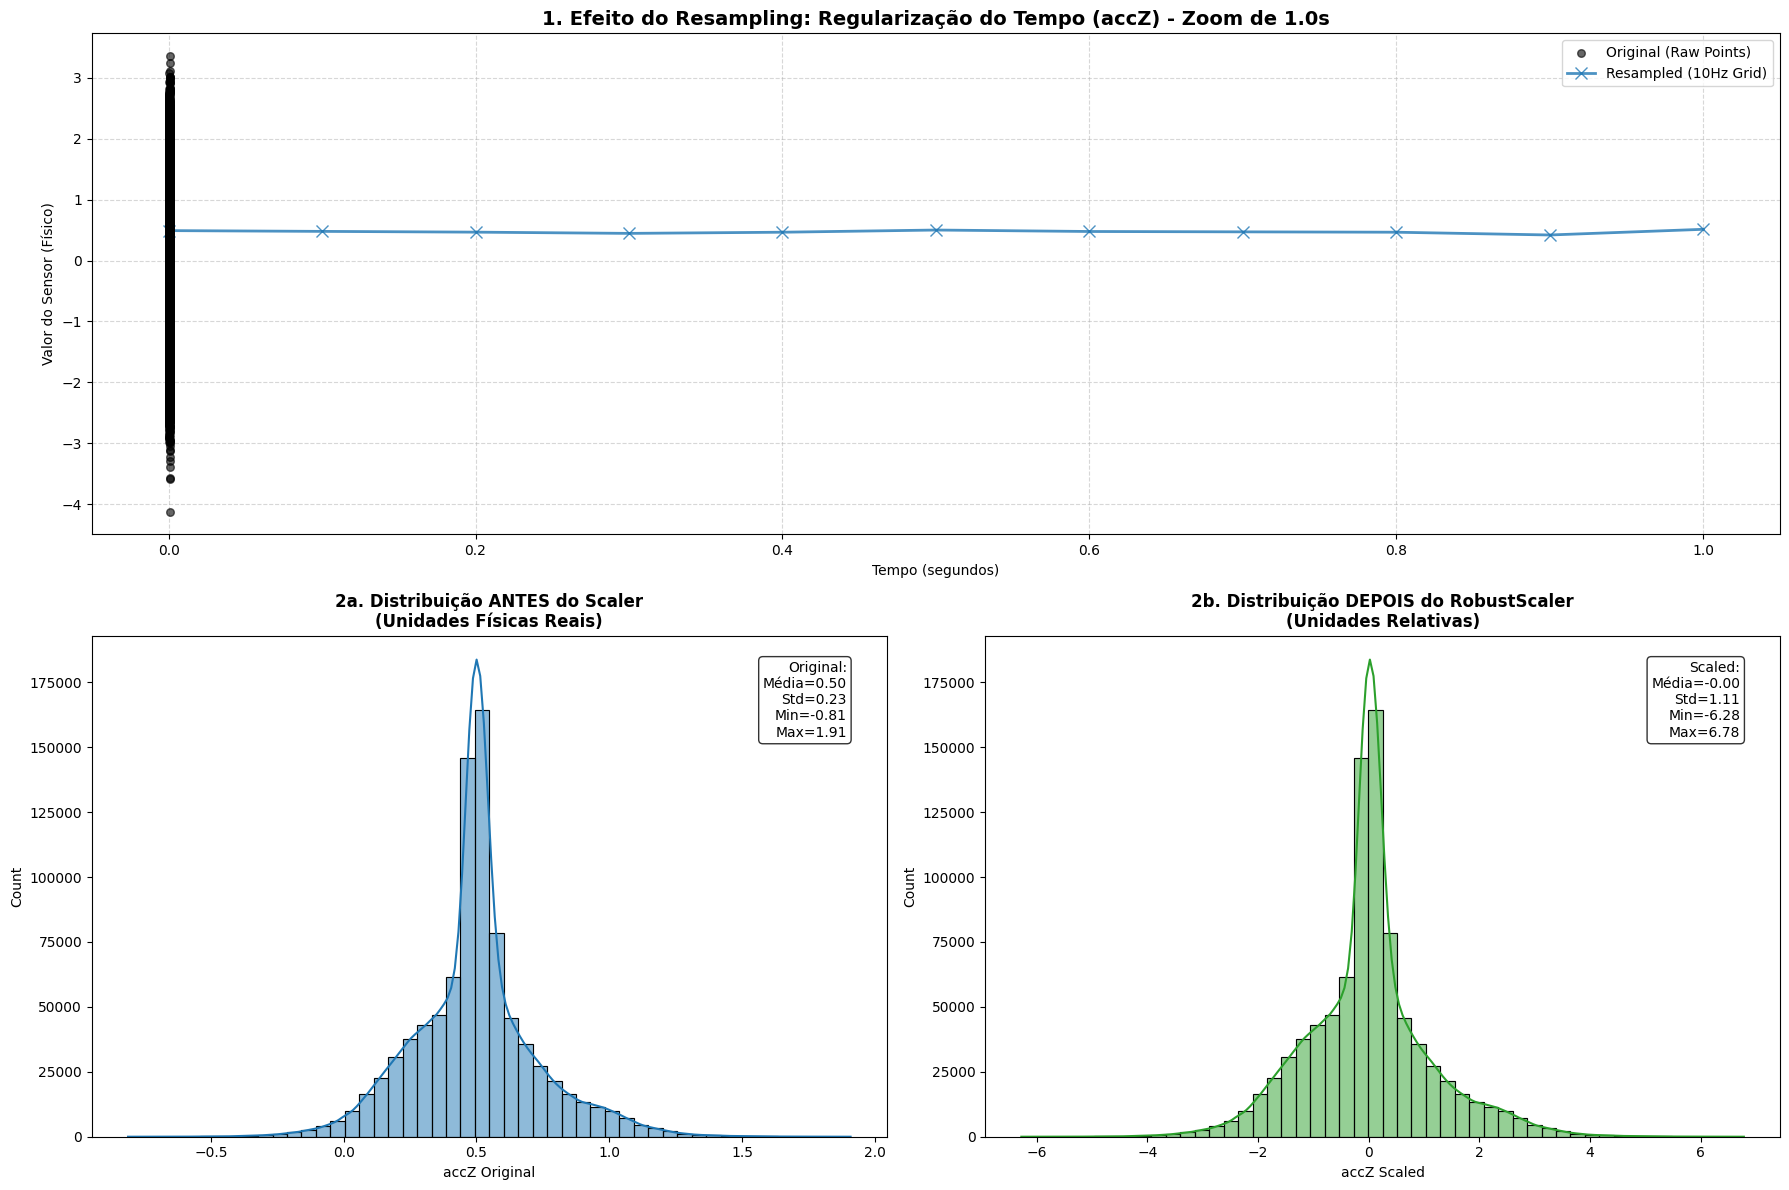

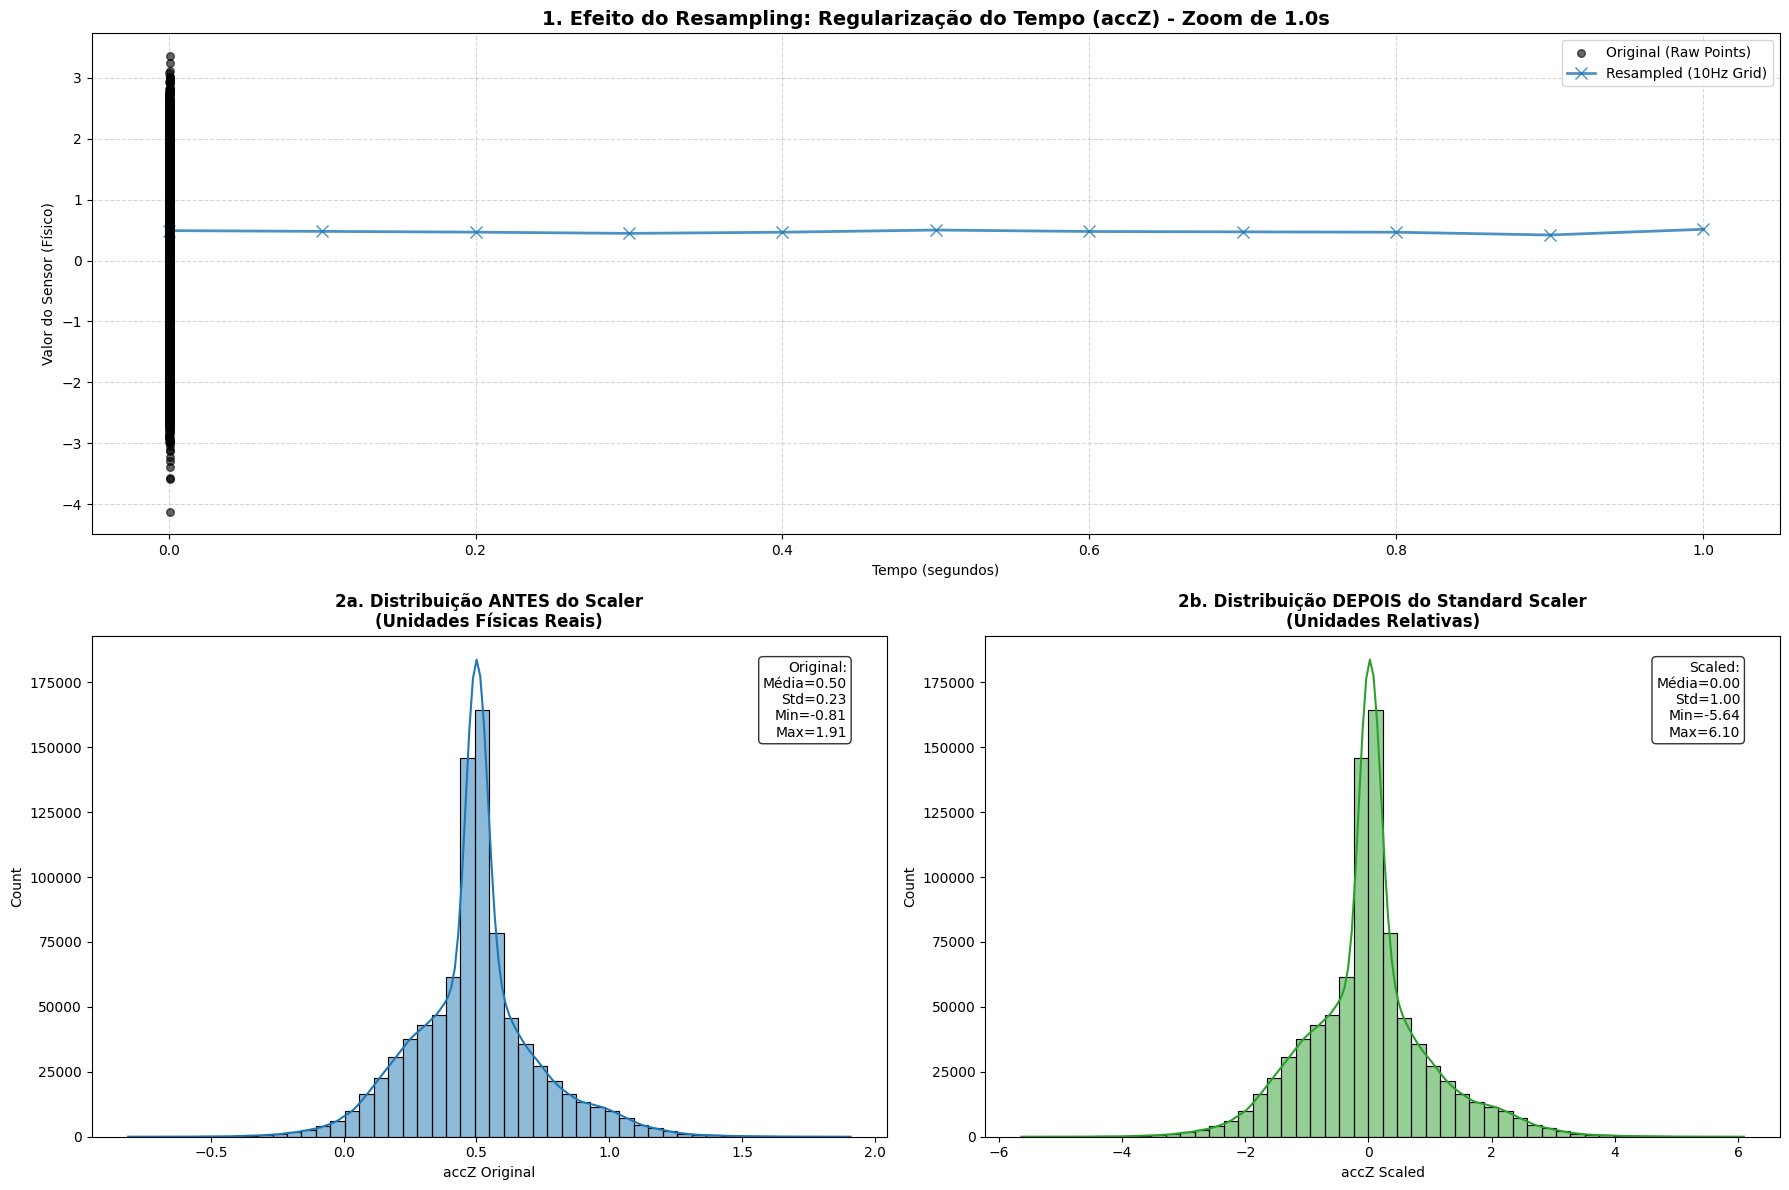

In [50]:
diagnostico_preprocessamento(df, df_normal_resampled, df_normal_scaled)
diagnostico_preprocessamento(df, df_normal_resampled, df_normal_standard_scaled, scaler_name="Standard Scaler")

## Análise Univariada
- Quantificar o quanto a distribuição de cada sensor muda quando o robô sai do estado "Normal" (0) para o estado "Falha" (1).

In [51]:
def analise_univariada_alvo(df_normal, df_falha, anomalia):
    """
    Realiza a análise univariada comparando atributos vs. alvo (Normal vs Falha).
    Gera estatísticas de separação e visualizações.
    """
    
    # 1. Preparar dados
    # Remover colunas não-sensor (time, label, name)
    cols_ignore = ['time', 'label', 'datetime', 'name']
    sensores = [c for c in df_normal.columns if c not in cols_ignore]
    
    stats_list = []
    
    # Configuração dos Plots
    # Vamos fazer um grid de 3 colunas
    n_cols = 3
    n_rows = (len(sensores) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
    axes = axes.flatten()
    
    print(f"Analisando {len(sensores)} sensores...\n")
    
    for i, sensor in enumerate(sensores):
        # Dados das duas classes
        data_norm = df_normal[sensor].dropna()
        data_fail = df_falha[sensor].dropna()
        
        # --- A. ESTATÍSTICA ---
        # 1. Diferença de Médias
        mean_diff = abs(data_fail.mean() - data_norm.mean())
        
        # 2. Razão de Variância (Quantas vezes a vibração aumentou?)
        # Adicionamos um epsilon pequeno para evitar divisão por zero
        var_ratio = data_fail.var() / (data_norm.var() + 1e-9)
        
        # 3. Teste Kolmogorov-Smirnov (Poder de Separação Geral)
        # statistic: 0 a 1 (quanto maior, melhor separa as classes)
        ks_stat, p_value = ks_2samp(data_norm, data_fail)
        
        stats_list.append({
            'Sensor': sensor,
            'KS_Statistic': ks_stat, # Principal métrica de separação
            'Variance_Ratio': var_ratio,
            'Mean_Diff': mean_diff,
            'P_Value': p_value
        })
        
        # --- B. VISUALIZAÇÃO (Violin Plot) ---
        # Criamos um mini-df temporário para o seaborn
        df_temp = pd.DataFrame({
            'Valor': np.concatenate([data_norm, data_fail]),
            'Estado': ['Normal'] * len(data_norm) + ['Falha'] * len(data_fail)
        })
        
        sns.violinplot(data=df_temp, x='Estado', y='Valor', ax=axes[i], 
                       palette={'Normal': '#1f77b4', 'Falha': '#d62728'}, split=False, hue='Estado')
        
        axes[i].set_title(f'{sensor}\nKS Stat: {ks_stat:.3f}', fontsize=10, fontweight='bold')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].grid(True, alpha=0.3)

    # Remover axes vazios se houver
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()
    
    # --- C. TABELA DE RANKING ---
    df_stats = pd.DataFrame(stats_list)
    # Ordenar pelo KS Statistic (Melhor separador primeiro)
    df_stats = df_stats.sort_values(by='KS_Statistic', ascending=False).reset_index(drop=True)
    
    print("="*80)
    print(f"{anomalia} - RANKING DE IMPORTÂNCIA DOS SENSORES (Baseado em KS-Test)")
    print("="*80)
    print("KS_Statistic: 1.0 = Separação Perfeita | 0.0 = Indistinguível")
    print("Variance_Ratio: > 1.0 = Falha aumentou a variabilidade")
    print("-" * 60)
    print(df_stats[['Sensor', 'KS_Statistic', 'Variance_Ratio', 'Mean_Diff']])
    
    return df_stats

In [52]:
def analise_univariada_sensor(
    df_normal,
    df_falha,
    sensor,
    anomalia=None,
    ax=None
):
    """
    Realiza análise univariada (Normal vs Falha) para UM sensor específico.
    Plota violin plot e gera tabela KS.
    
    Args:
        df_normal (DataFrame): dados normais
        df_falha (DataFrame): dados de falha
        sensor (str): nome da coluna do sensor
        anomalia (str, optional): nome da anomalia (para título/log)
        ax (matplotlib axis, optional): eixo para plot (útil em grids)
        
    Returns:
        DataFrame com métricas estatísticas do sensor
    """

    # --- 1. Validação ---
    if sensor not in df_normal.columns or sensor not in df_falha.columns:
        raise ValueError(f"Sensor '{sensor}' não encontrado nos DataFrames")

    # --- 2. Dados das duas classes ---
    data_norm = df_normal[sensor].dropna()
    data_fail = df_falha[sensor].dropna()

    # --- 3. Estatísticas ---
    mean_diff = abs(data_fail.mean() - data_norm.mean())
    var_ratio = data_fail.var() / (data_norm.var() + 1e-9)
    ks_stat, p_value = ks_2samp(data_norm, data_fail)

    df_stats = pd.DataFrame([{
        'Sensor': sensor,
        'KS_Statistic': ks_stat,
        'Variance_Ratio': var_ratio,
        'Mean_Diff': mean_diff,
        'P_Value': p_value
    }])

    # --- 4. Violin Plot ---
    df_temp = pd.DataFrame({
        'Valor': np.concatenate([data_norm, data_fail]),
        'Estado': ['Normal'] * len(data_norm) + ['Falha'] * len(data_fail)
    })

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    sns.violinplot(
        data=df_temp,
        x='Estado',
        y='Valor',
        hue='Estado',
        ax=ax,
        split=False,
        legend=False
    )

    titulo = f'{sensor}\nKS Stat: {ks_stat:.3f}'
    if anomalia:
        titulo = f'{anomalia} | {titulo}'

    ax.set_title(titulo, fontsize=11, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(True, alpha=0.3)

    if ax is None:
        plt.tight_layout()
        plt.show()

    # --- 5. Print da tabela ---
    print("=" * 70)
    print("ANÁLISE UNIVARIADA - SENSOR ÚNICO")
    if anomalia:
        print(f"Anomalia: {anomalia}")
    print(f"Sensor: {sensor}")
    print("-" * 70)
    print("KS_Statistic: 1.0 = Separação Perfeita | 0.0 = Indistinguível")
    print(df_stats[['Sensor', 'KS_Statistic', 'Variance_Ratio', 'Mean_Diff']])

    return df_stats


In [53]:
arquivos_falha = [
    'IMU_hitting_platform.csv',   # Colisão: Plataforma
    'IMU_hitting_arm.csv',        # Colisão: Braço (Robô se batendo)
    'IMU_extra_weigth.csv',       # Mecânico: Peso Extra (Esforço)
    'IMU_earthquake.csv',         # Ambiental: Terremoto (Vibração externa)
]

ANÁLISE UNIVARIADA - SENSOR ÚNICO
Anomalia: IMU_extra_weigth.csv
Sensor: accZ
----------------------------------------------------------------------
KS_Statistic: 1.0 = Separação Perfeita | 0.0 = Indistinguível
  Sensor  KS_Statistic  Variance_Ratio  Mean_Diff
0   accZ      0.752219        0.775754   0.466638


Sensor  KS_Statistic  Variance_Ratio  Mean_Diff  P_Value
0   accZ      0.752219        0.775754   0.466638      0.0

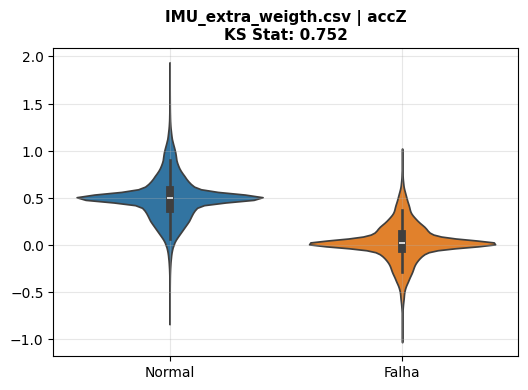

In [57]:
anomalia = 'IMU_extra_weigth.csv'
analise_univariada_sensor(
    df_normal_resampled,
    faultydfs_resampled[anomalia],
    sensor='accZ',
    anomalia=anomalia
)


ANOMALIA: IMU_hitting_platform.csv
Analisando 9 sensores...



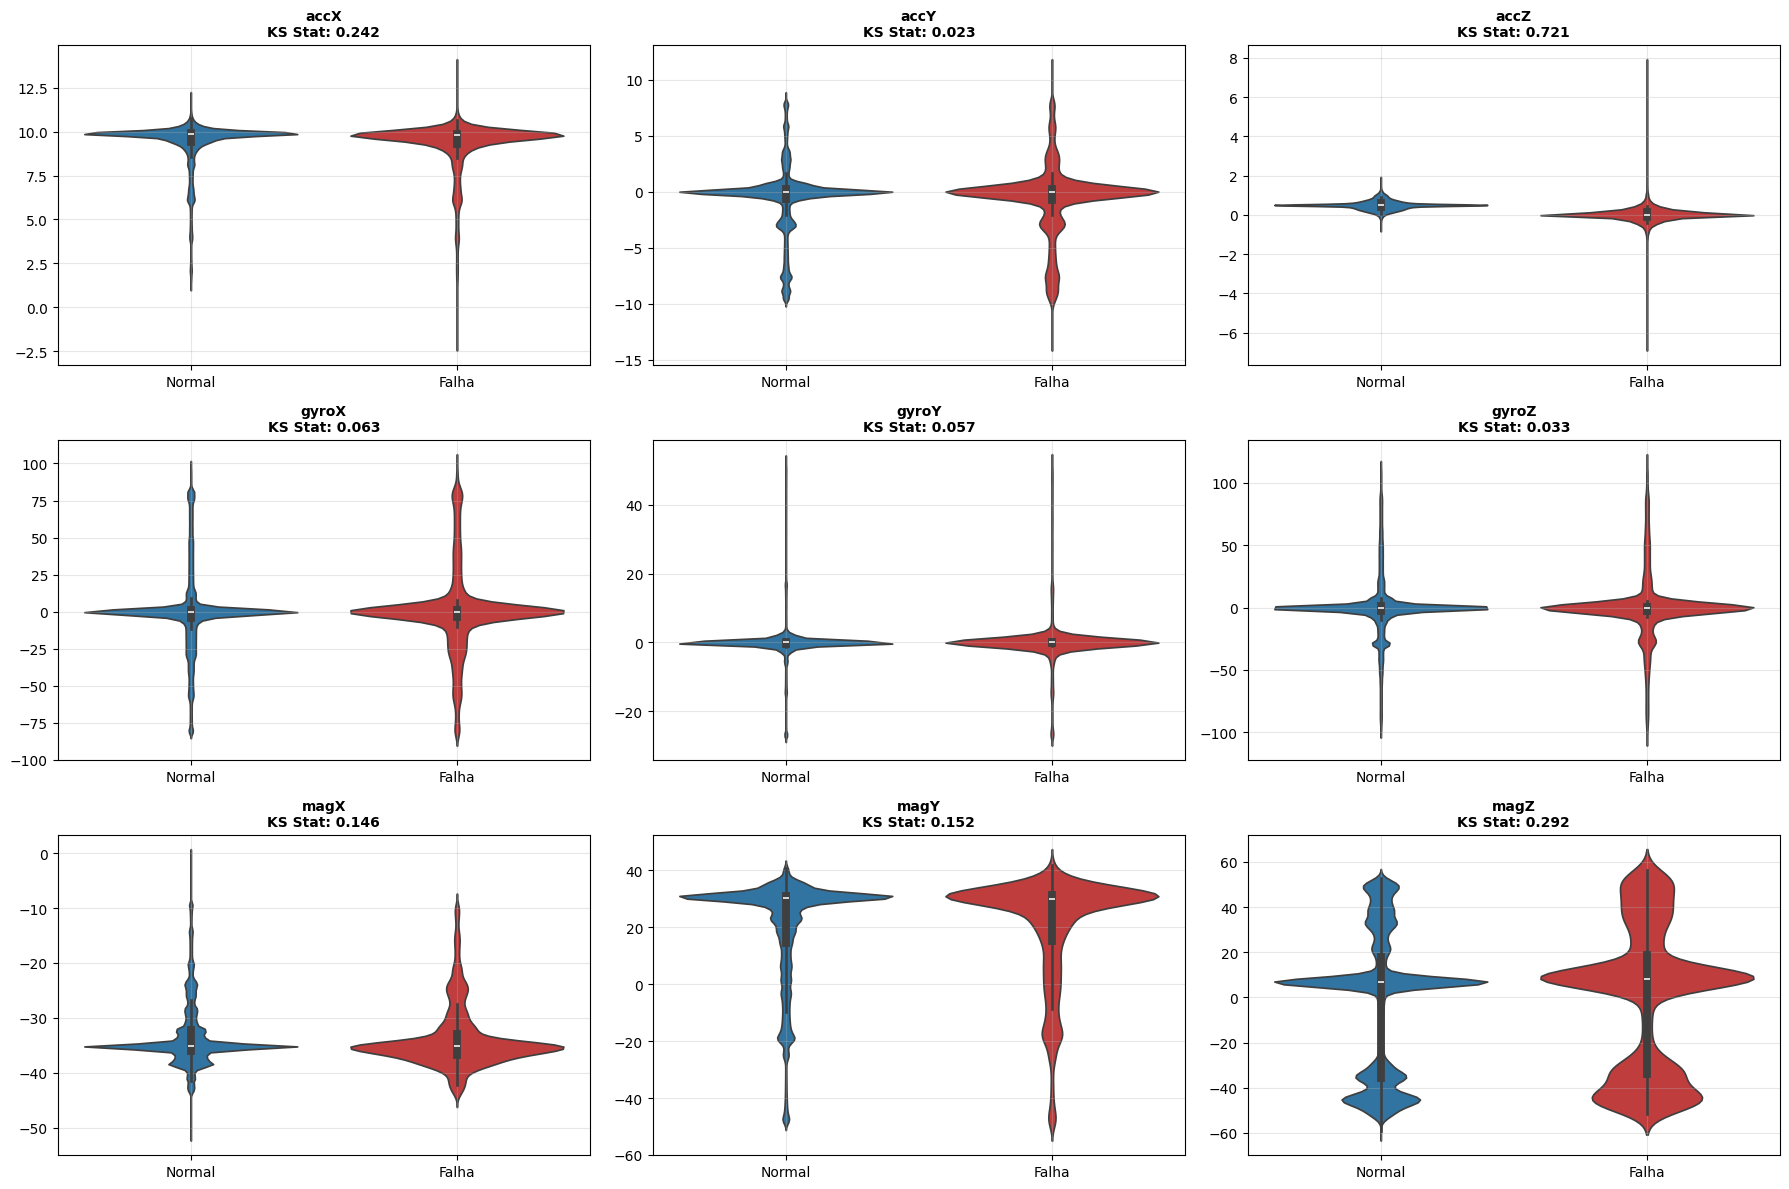

IMU_hitting_platform.csv - RANKING DE IMPORTÂNCIA DOS SENSORES (Baseado em KS-Test)
KS_Statistic: 1.0 = Separação Perfeita | 0.0 = Indistinguível
Variance_Ratio: > 1.0 = Falha aumentou a variabilidade
------------------------------------------------------------
  Sensor  KS_Statistic  Variance_Ratio  Mean_Diff
0   accZ      0.720720        3.254453   0.476748
1   magZ      0.291977        1.022086   1.961425
2   accX      0.242462        1.031887   0.070068
3   magY      0.152211        1.001719   0.361481
4   magX      0.145993        0.951192   0.495011
5  gyroX      0.063415        0.998307   0.070330
6  gyroY      0.057022        0.974871   0.007856
7  gyroZ      0.032900        0.995919   0.023760
8   accY      0.023361        1.009183   0.010511

ANOMALIA: IMU_hitting_arm.csv
Analisando 9 sensores...



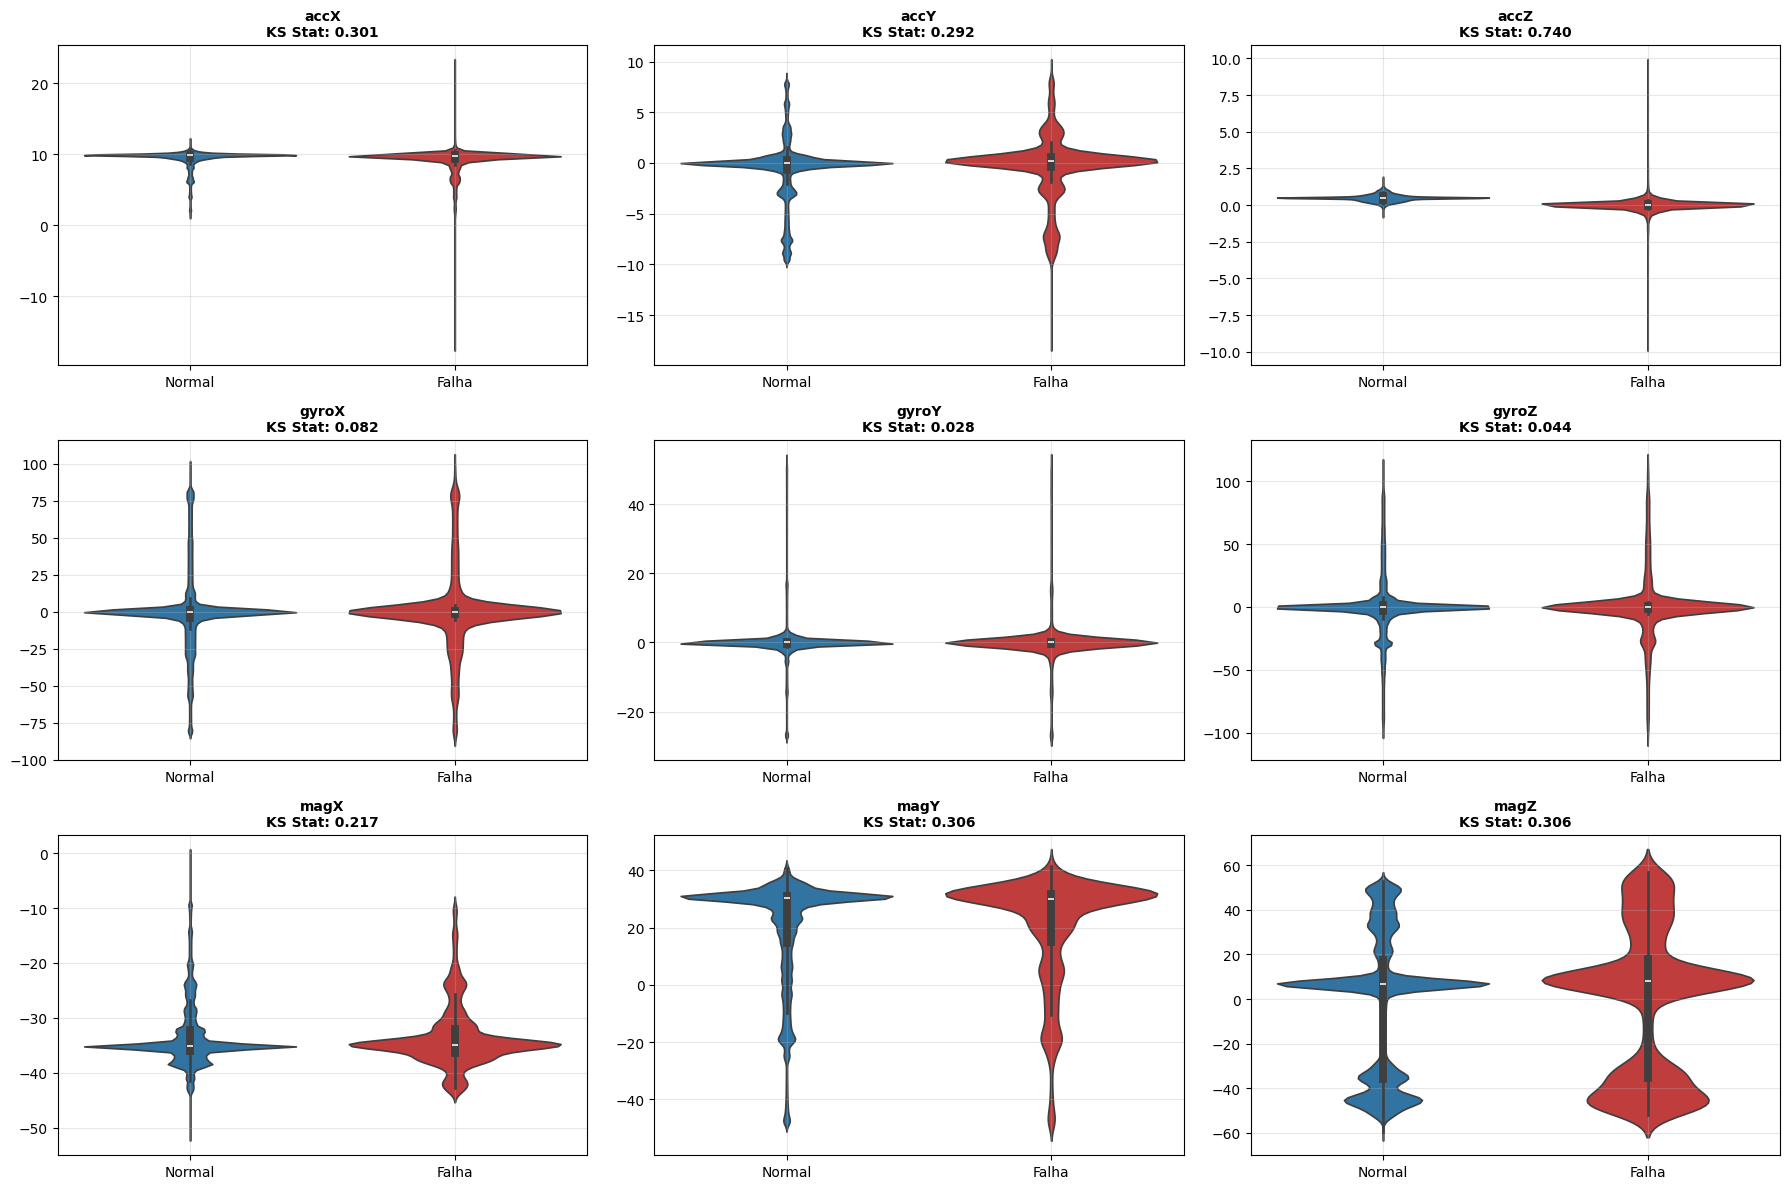

IMU_hitting_arm.csv - RANKING DE IMPORTÂNCIA DOS SENSORES (Baseado em KS-Test)
KS_Statistic: 1.0 = Separação Perfeita | 0.0 = Indistinguível
Variance_Ratio: > 1.0 = Falha aumentou a variabilidade
------------------------------------------------------------
  Sensor  KS_Statistic  Variance_Ratio  Mean_Diff
0   accZ      0.739871        3.278829   0.478858
1   magY      0.305590        0.992796   0.430049
2   magZ      0.305586        1.088366   0.954359
3   accX      0.300607        1.139457   0.069925
4   accY      0.292061        0.997899   0.323414
5   magX      0.216849        0.945436   0.187405
6  gyroX      0.081790        0.905517   0.064596
7  gyroZ      0.044330        0.908278   0.012673
8  gyroY      0.028003        0.877819   0.133292

ANOMALIA: IMU_extra_weigth.csv
Analisando 9 sensores...



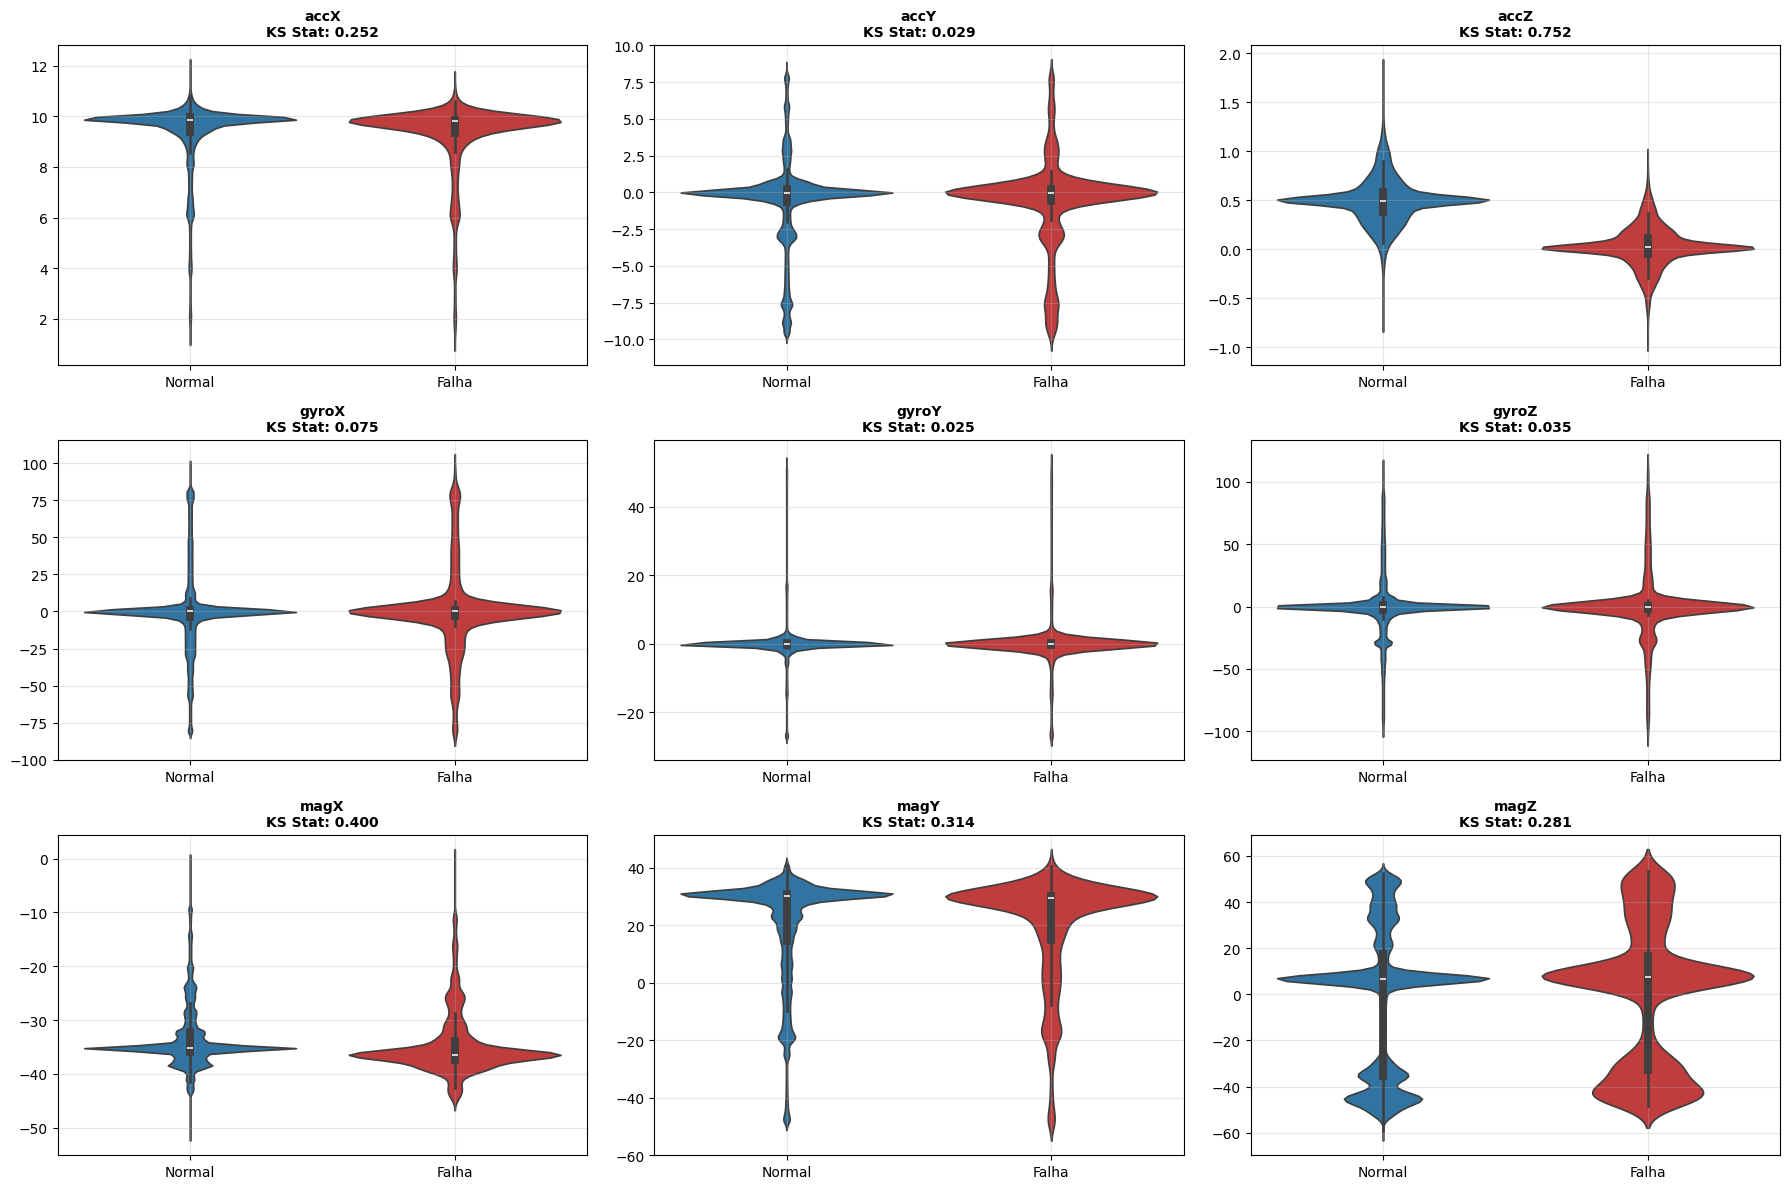

IMU_extra_weigth.csv - RANKING DE IMPORTÂNCIA DOS SENSORES (Baseado em KS-Test)
KS_Statistic: 1.0 = Separação Perfeita | 0.0 = Indistinguível
Variance_Ratio: > 1.0 = Falha aumentou a variabilidade
------------------------------------------------------------
  Sensor  KS_Statistic  Variance_Ratio  Mean_Diff
0   accZ      0.752219        0.775754   0.466638
1   magX      0.399756        0.927407   1.389923
2   magY      0.313641        0.968139   0.183171
3   magZ      0.281270        0.943271   1.864200
4   accX      0.252118        0.970057   0.060506
5  gyroX      0.075041        0.992324   0.028772
6  gyroZ      0.034927        0.994015   0.026585
7   accY      0.028757        0.978588   0.015635
8  gyroY      0.024722        0.965224   0.040777

ANOMALIA: IMU_earthquake.csv
Analisando 9 sensores...



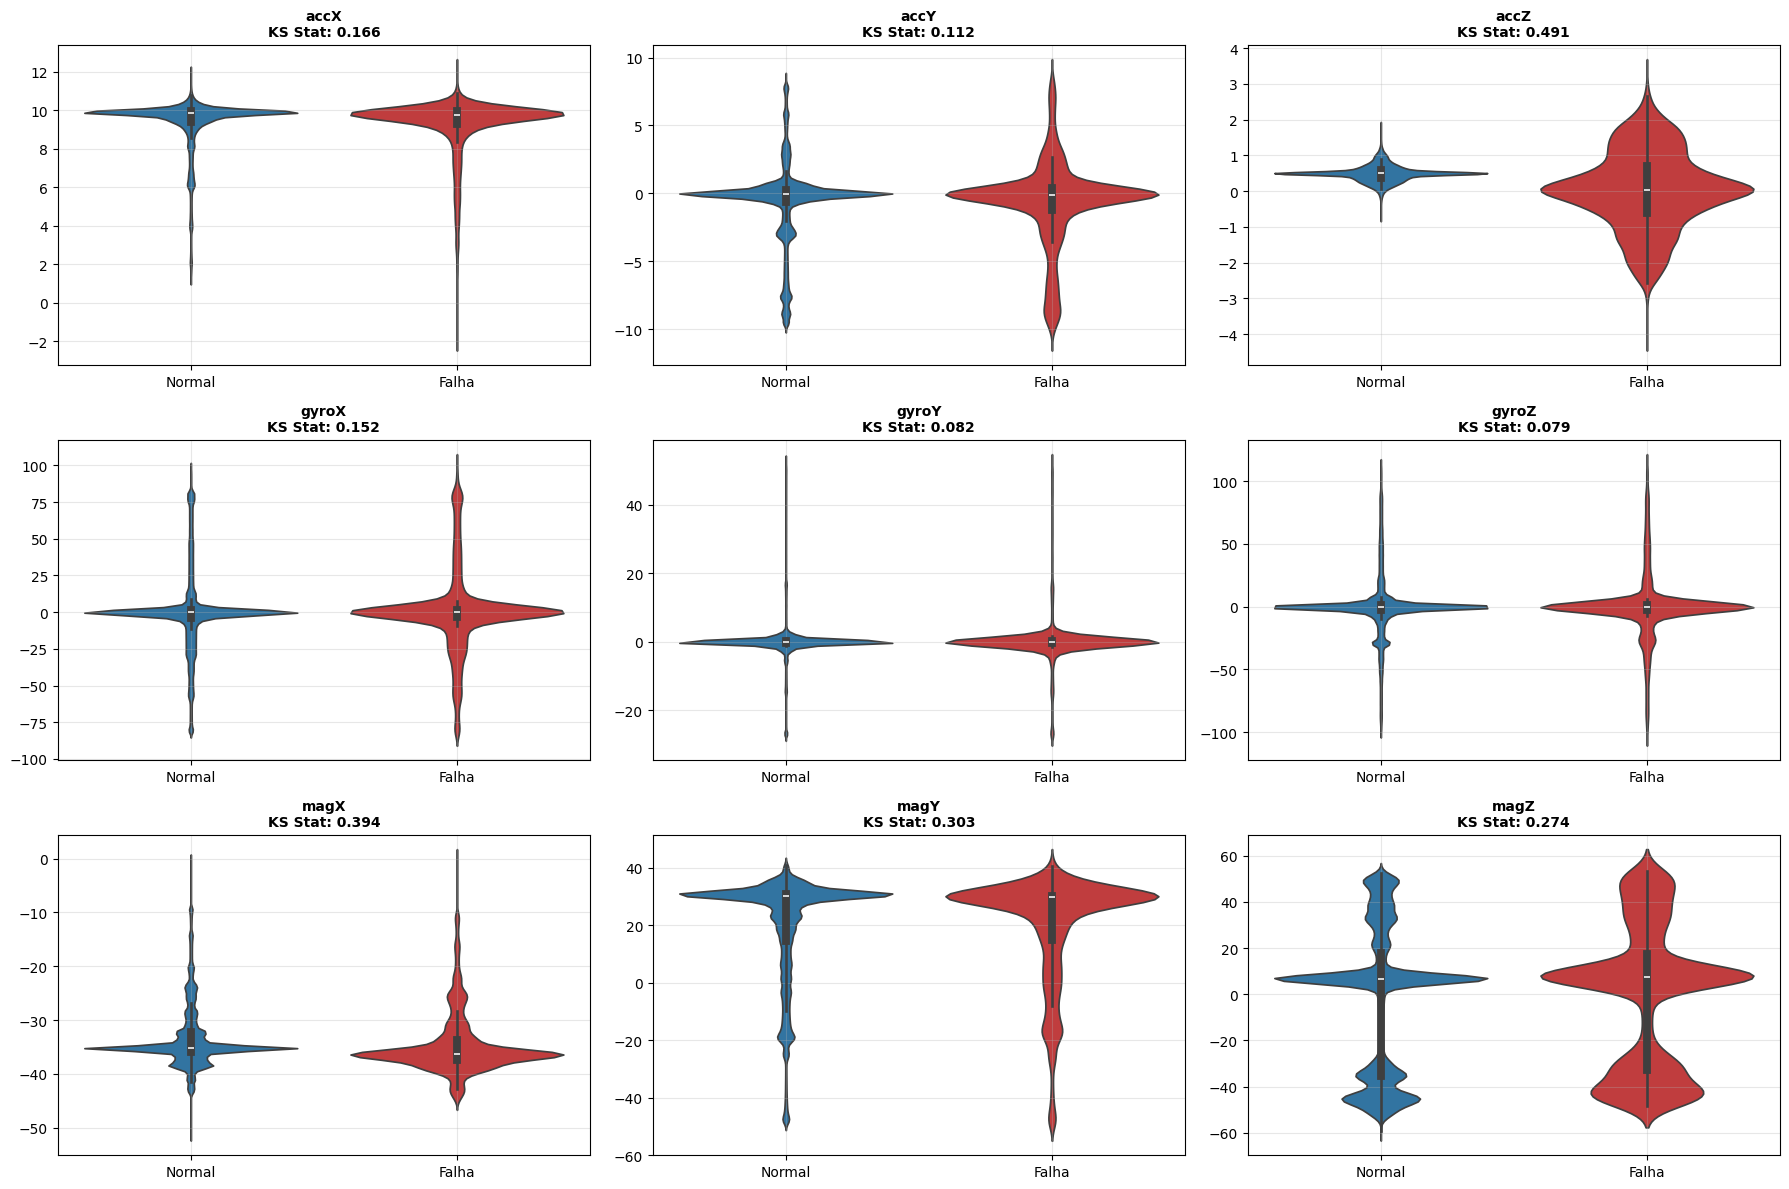

IMU_earthquake.csv - RANKING DE IMPORTÂNCIA DOS SENSORES (Baseado em KS-Test)
KS_Statistic: 1.0 = Separação Perfeita | 0.0 = Indistinguível
Variance_Ratio: > 1.0 = Falha aumentou a variabilidade
------------------------------------------------------------
  Sensor  KS_Statistic  Variance_Ratio  Mean_Diff
0   accZ      0.490960       22.401641   0.465277
1   magX      0.394022        0.936996   1.298403
2   magY      0.302740        0.972449   0.156790
3   magZ      0.274221        0.946418   1.828433
4   accX      0.165745        1.094727   0.070284
5  gyroX      0.152320        1.001379   0.094704
6   accY      0.111592        1.063816   0.007265
7  gyroY      0.081975        0.973825   0.079888
8  gyroZ      0.078750        0.996157   0.040511


In [32]:
for name, anomaly_resampled in faultydfs_resampled.items():
  print("\n"+"="*60)
  print(f'ANOMALIA: {name}')
  print("="*60)
  analise_univariada_alvo(df_normal_resampled, anomaly_resampled, name) 

## PREPARAÇÃO DOS DADOS
- aplicando filtragem Savitzky–Golay para reduzir o ruído dos sensores

In [33]:
cols = ["accX", "accY","accZ","gyroX", "gyroY", "gyroZ", "magX", "magY", "magZ"]

In [34]:
df.loc[:, cols].describe( #remover time e label
        ).T.style.format("{:.4f}"
        ).background_gradient(cmap="Blues")

In [35]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
def plotSensors(dfPlot, step=1,suptitle="SENSORES AO LONGO DE 1 MINUTO\n",startTimeIdx=None,endTimeIdx=None):
    df = dfPlot.iloc[::step]
    fig = plt.figure(figsize=(25, 15))

    if not any((startTimeIdx, endTimeIdx)):
        startTimeIdx,endTimeIdx =  df['time'].iloc[0],df['time'].iloc[-1]
    else:
        startTimeIdx,endTimeIdx =  df['time'].iloc[startTimeIdx],df['time'].iloc[endTimeIdx]

    # Helper to plot three axes in the same subplot
    def plotSensorsSameGraph(ax, cols, title, x="time"):
        for col in cols:
            mask = (df['time'] >= startTimeIdx) & (df['time'] < endTimeIdx)
            ax.plot(df[mask][x], df[mask][col], label=col)

        ax.set_title(title, fontsize=18)
        ax.set_xlabel(x)
        ax.set_ylabel("value")
        ax.legend(loc='lower left')

    # === Subplots ===
    ax1 = fig.add_subplot(3, 1, 1)
    plotSensorsSameGraph(ax1,
                         cols=["accX", "accY","accZ"],
                         title="Accelerometer (X, Y, Z)")

    ax2 = fig.add_subplot(3, 1, 2)
    plotSensorsSameGraph(ax2,
                         cols=["gyroZ","gyroX", "gyroY", ],
                         title="Gyroscope (X, Y, Z)")

    ax3 = fig.add_subplot(3, 1, 3)
    plotSensorsSameGraph(ax3,
                         cols=["magZ", "magY", "magX"],
                         title="Magnetometer (X, Y, Z)")
    plt.suptitle(suptitle, fontsize='18')
    plt.tight_layout()
    plt.show()
plotSensors(df,startTimeIdx=20050, endTimeIdx=20050 + 60*10)
plotSensors(df,suptitle="SENSORES")

IndexError: single positional indexer is out-of-bounds

<Figure size 2500x1500 with 0 Axes>

In [ ]:
from scipy.signal import savgol_filter
# Savitzky-golay, um filtro bom pra series temporais (inspirado por https://www.nixtla.io/blog/polynomial_filtering)
for col in cols:
  df[col + "_smooth"] = savgol_filter(df[col], window_length=8, polyorder=2)


In [ ]:
sensor_groups = [
    ("Accelerometer", ["accX", "accY", "accZ"]),
    ("Gyroscope", ["gyroX", "gyroY", "gyroZ"]),
    ("Magnetometer", ["magX", "magY", "magZ"])
]
def plot_raw_vs_smooth(df,step=10):
    fig, axes = plt.subplots(3, 3, figsize=(32, 24))
    df = df.iloc[::step]

    for row, (title, cols) in enumerate(sensor_groups):
        for col, axis in enumerate(cols):
            ax = axes[row][col]

            raw = df[axis]
            smooth = df[axis + "_smooth"]

            ax.plot(df["time"], raw, label="raw", alpha=0.35)
            ax.plot(df["time"], smooth, label="smooth", linewidth=2)

            ax.set_title(f"{title} — {axis}", fontsize=16)
            ax.set_xlabel("time")
            ax.set_ylabel("value")
            ax.legend()

    plt.tight_layout()
    plt.show()
plot_raw_vs_smooth(df)

## Comparação antes e depois da filtragem

1. adicionar a imagem aqui porque é muito lento pra calcular)

1. Adicionar metricas de ruído
